
# Bitcoin Price Prediction

The goal of this case study is to use classification based models to predict whether the current signal is **buy or sell** depending on the short term vs long term price.


* Daniel Roberts - 1005809760
* Tiffany Costas - 1005854844
* Edwardo Bassil - 1010830969


## Content

<a id='0'></a>
# 1. Problem Definition

The problem of predicting a buy or sell signal for a trading strategy is defined in the
classification framework, where the predicted variable has a value of 1 for buy and 0
for sell.

The buy or sell signal are decided on the basis on the comparison of short term vs. long
term price.

For the purpose of presented case study, we get the data from one of the largest Bit‐
coin exchanges in terms of average daily volume traded—Bitstamp (https://
www.bitstamp.com). Data can be found at: https://www.kaggle.com/mczielinski/bitcoin-historical-data

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>




## 2.1. Loading the python packages

In [ ]:
# fix missing libraries
!pip install scikit-learn --upgrade
!pip install ta
!pip install shap
!pip install --upgrade shap
!pip install warnings

In [ ]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.stats import pearsonr
from sklearn.metrics import balanced_accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import os
import time
import warnings
warnings.filterwarnings('ignore')
import multiprocessing
import concurrent.futures
import shap
import ta

<a id='1.2'></a>
## 2.2. Loading the Data

In [ ]:
cwd = os.getcwd()
file_name = 'btcusd_1-min_data.csv'
path = os.path.join(cwd, file_name)
df = pd.read_csv(path)
df.head()

,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0


<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [ ]:
df.shape

(6726281, 6)

In [ ]:
nan_vals = df.isnull().values.any()
print(nan_vals)
print(df.isnull().sum())

True
Timestamp    1
Open         0
High         0
Low          0
Close        0
Volume       0
dtype: int64


In [ ]:
df = df.dropna()
nan_vals = df.isnull().values.any()
print(nan_vals)
if nan_vals == True:
    df[df.columns.values] = df[df.columns.values].ffill()

df = df.drop(columns = ['Timestamp'])

False


In [ ]:
df.describe()

,Open,High,Low,Close,Volume
count,6.726280e+06,6.726280e+06,6.726280e+06,6.726280e+06,6.726280e+06
mean,1.442206e+04,1.442830e+04,1.441563e+04,1.442208e+04,5.471225e+00
std,1.942030e+04,1.942784e+04,1.941264e+04,1.942040e+04,2.295818e+01
min,3.800000e+00,3.800000e+00,3.800000e+00,3.800000e+00,0.000000e+00
25%,4.123300e+02,4.125000e+02,4.121300e+02,4.123275e+02,1.828378e-02
50%,6.238990e+03,6.241245e+03,6.235740e+03,6.238990e+03,5.000000e-01
75%,2.304444e+04,2.305200e+04,2.303689e+04,2.304401e+04,3.186951e+00
max,1.036260e+05,1.036470e+05,1.036180e+05,1.036250e+05,5.853852e+03


In [ ]:
df.tail(3)

,Open,High,Low,Close,Volume
6726277,97430.0,97450.0,97429.0,97450.0,0.001500
6726278,97462.0,97487.0,97462.0,97468.0,0.023377
6726279,97318.0,97340.0,97277.0,97340.0,0.003834


<a id='3'></a>
# 4. Data Preparation

In [ ]:
df["WTD_Price"] = df[["Open", "High", "Low", "Close"]].mean(axis=1)
df.head(3)

,Open,High,Low,Close,Volume,WTD_Price
0,4.58,4.58,4.58,4.58,0.0,4.58
1,4.58,4.58,4.58,4.58,0.0,4.58
2,4.58,4.58,4.58,4.58,0.0,4.58


First we will generate the original signals from the sample project.

Next we will test and evaluate how well the signals works at generating good returns. We will use multiple metrics such as carg, sharpe, win rates and cumulative returns.

We will utilise 4 methodologies of how the price returns and strategy returns will be generated

This is to ensure that metrics are generated in a realistic environment, in which when a signal is generated, the investor/program will be able to act on it

Additionally lookahead biaas is accounted for some methodologies to ensure that only historical data is utilised when targets are classified.

Generate classification targets

In [ ]:
# Original Signal for comparison
# Create short simple moving average over the short window
df['short_mavg'] = df['Close'].rolling(window=10, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
df['long_mavg'] = df['Close'].rolling(window=60, min_periods=1, center=False).mean()

# Create signals
df['signal_org'] = np.where(df['short_mavg'] > df['long_mavg'], 1.0, 0.0)

nan_vals = df.isnull().values.any()
print(nan_vals)

False


In [ ]:
df_org = df.copy()

In [ ]:
# TESTING STRATEGY RETURNS WITH DIFFERENT METHODS OF CALCULATING RETURNS
print("METHOD 1")
df_org['price_rets1'] = df_org['Open'].shift(-1).pct_change(fill_method = None).fillna(0)
df_org['cum_price_rets1'] = (1 + df_org['price_rets1']).cumprod() - 1
df_org['strat_rets1'] = (df_org['price_rets1'].shift(-1) * df_org['signal_org']).fillna(0)
df_org['cum_rets1'] = (1 + df_org['strat_rets1']).cumprod() - 1

# CAGR (compound annual growth rate)
cagr = (1 + df_org['cum_rets1'].iloc[-1]) ** (1440 * 365 / len(df_org['cum_rets1'])) - 1

# Sharpe Ratio (annualized)
annualization_factor = np.sqrt(1440 * 365)
sharpe_org =  (annualization_factor * df_org['strat_rets1'].mean()) / (df_org['strat_rets1'].std())

# 3. Win Rate
signal_changes = df_org['signal_org'].diff().fillna(0)
trade_points = signal_changes != 0
trade_num = trade_points.cumsum()
trade_rets = df_org.loc[trade_points, 'strat_rets1'].dropna()
win_trades = (trade_rets > 0).sum()
total_trades = len(trade_rets)
win_rate = win_trades / total_trades if total_trades > 0 else 0

print(f'Total Trades: {total_trades}')
print(f'Winning Trades: {win_trades}')
print(f'Win Rate: {win_rate:.3f}')
print(f'Original Strategy Sharpe: {sharpe_org:.3f}')
print(f'CAGR: {cagr:.3f}')
print(f"Strategy Total Return: {df_org['cum_rets1'].iloc[-1]}")
print(f'Open - Open Cumulative Price Return: {df_org["cum_price_rets1"].iloc[-1]}')

print('##############')
print("METHOD 2")
df_org['price_rets1'] = ((df_org['Open'].shift(-1) - df_org['Close']) / df_org['Close']).fillna(0)
df_org['cum_price_rets1'] = (1 + df_org['price_rets1']).cumprod() - 1
df_org['strat_rets1'] = (df_org['price_rets1'].shift(-1) * df_org['signal_org']).fillna(0)
df_org['cum_rets1'] = (1 + df_org['strat_rets1']).cumprod() - 1

# CAGR (compound annual growth rate)
cagr = (1 + df_org['cum_rets1'].iloc[-1]) ** (1440 * 365 / len(df_org['cum_rets1'])) - 1

# Sharpe Ratio (annualized)
annualization_factor = np.sqrt(1440 * 365)
sharpe_org =  (annualization_factor * df_org['strat_rets1'].mean()) / (df_org['strat_rets1'].std())

# Win Rate
signal_changes = df_org['signal_org'].diff().fillna(0)
trade_points = signal_changes != 0
trade_num = trade_points.cumsum()
trade_rets = df_org.loc[trade_points, 'strat_rets1'].dropna()
winning_trades = (trade_rets > 0).sum()
total_trades = len(trade_rets)
win_rate = winning_trades / total_trades if total_trades > 0 else 0

print(f'Total Trades: {total_trades}')
print(f'Winning Trades: {winning_trades}')
print(f'Win Rate: {win_rate:.3f}')
print(f'Original Strategy Sharpe: {sharpe_org:.3f}')
print(f'CAGR: {cagr:.3f}')
print(f"Strategy Total Return: {df_org['cum_rets1'].iloc[-1]}")
print(f'Prev Open - Curr Close Cumulative Price Return: {df_org["cum_price_rets1"].iloc[-1]}')

print('##############')
print("METHOD 3")
df_org['price_rets1'] = ((df_org['Close'] - df_org['Open']) / df_org['Open']).fillna(0)
df_org['cum_price_rets1'] = (1 + df_org['price_rets1']).cumprod() - 1
df_org['strat_rets1'] = (df_org['price_rets1']*df_org['signal_org']).fillna(0)
df_org['cum_rets1'] = (1 + df_org['strat_rets1']).cumprod() - 1

# CAGR (compound annual growth rate)
cagr = (1 + df_org['cum_rets1'].iloc[-1]) ** (1440 * 365 / len(df_org['cum_rets1'])) - 1

# Sharpe Ratio (annualized)
annualization_factor = np.sqrt(1440 * 365)
sharpe_org =  (annualization_factor * df_org['strat_rets1'].mean()) / (df_org['strat_rets1'].std())

# Win Rate
signal_changes = df_org['signal_org'].diff().fillna(0)
trade_points = signal_changes != 0
trade_num = trade_points.cumsum()
trade_rets = df_org.loc[trade_points, 'strat_rets1'].dropna()
winning_trades = (trade_rets > 0).sum()
total_trades = len(trade_rets)  # Divide by 2 as each trade has entry and exit
win_rate = winning_trades / total_trades if total_trades > 0 else 0
print(f'Total Trades: {total_trades}')
print(f'Winning Trades: {winning_trades}')
print(f'Win Rate: {win_rate:.3f}')
print(f'Original Strategy Sharpe: {sharpe_org:.3f}')
print(f'CAGR: {cagr:.3f}')
print(f"Strategy Total Return: {df_org['cum_rets1'].iloc[-1]}")
print(f'Open - Close Cumulative Price Return: {df_org["cum_price_rets1"].iloc[-1]}')

print('################')
print("METHOD 4")
df_org['price_rets1'] = ((df_org['Close'].shift(-1) - df_org['Open'].shift(-1)) / df_org['Open'].shift(-1)).fillna(0)
df_org['cum_price_rets1'] = (1 + df_org['price_rets1']).cumprod() - 1
df_org['strat_rets1'] = (df_org['price_rets1'] * df_org['signal_org']).fillna(0)
df_org['cum_rets1'] = (1 + df_org['strat_rets1']).cumprod() - 1

# CAGR (compound annual growth rate)
cagr = (1 + df_org['cum_rets1'].iloc[-1]) ** (1440 * 365 / len(df_org['cum_rets1'])) - 1

# Sharpe Ratio (annualized)
annualization_factor = np.sqrt(1440 * 365)
sharpe_org =  (annualization_factor * df_org['strat_rets1'].mean()) / (df_org['strat_rets1'].std())

# Win Rate
signal_changes = df_org['signal_org'].diff().fillna(0)
trade_points = signal_changes != 0
trade_num = trade_points.cumsum()
trade_rets = df_org.loc[trade_points, 'strat_rets1'].dropna()
winning_trades = (trade_rets > 0).sum()
total_trades = len(trade_rets)
win_rate = winning_trades / total_trades if total_trades > 0 else 0

print(f'Total Trades: {total_trades}')
print(f'Winning Trades: {winning_trades}')
print(f'Win Rate: {win_rate:.3f}')
print(f'Original Strategy Sharpe: {sharpe_org:.3f}')
print(f'CAGR: {cagr:.3f}')
print(f"Strategy Total Return: {df_org['cum_rets1'].iloc[-1]}")
print(f'Open - Close Cumulative Price Return: {df_org["cum_price_rets1"].iloc[-1]}')
print(f"Buy First Open & Hold to Last Close Return: {(df_org['Close'].iloc[-1] - df_org['Open'].iloc[0]) / df_org['Open'].iloc[0]:.3f}")

METHOD 1
Total Trades: 245071
Winning Trades: 35283
Win Rate: 0.144
Original Strategy Sharpe: -2.674
CAGR: -0.922
Strategy Total Return: -0.9999999999999934
Open - Open Cumulative Price Return: 21247.471615735067
##############
METHOD 2
Total Trades: 245071
Winning Trades: 28105
Win Rate: 0.115
Original Strategy Sharpe: -2.831
CAGR: -0.877
Strategy Total Return: -0.9999999999977814
Prev Open - Curr Close Cumulative Price Return: 2.7564032682961904e+17
##############
METHOD 3
Total Trades: 245071
Winning Trades: 40222
Win Rate: 0.164
Original Strategy Sharpe: 7.419
CAGR: 157.451
Strategy Total Return: 1.4216969880648548e+28
Open - Close Cumulative Price Return: -0.9999999999999228
################
METHOD 4
Total Trades: 245071
Winning Trades: 30627
Win Rate: 0.125
Original Strategy Sharpe: -0.244
CAGR: -0.365
Strategy Total Return: -0.9970228999178196
Open - Close Cumulative Price Return: -0.9999999999999228
Buy First Open & Hold to Last Close Return: 21252.275


Based on the results we can see that Method 4 presents us with the most appropriate methodology for evaluation.

This is because a sharpe between -1 and 1 is very aligned with logic, and the slightly negative sharpe is what would have been predicted as it is well known that making trading decisions solely off of the moving average cross over will not yield good results. This is not to say its not a good indicator, its just that it needs to be used in combination with other signals to be useful in the long run

So we also see that the returns we could generate from simply buying bitcoin at first open and holding without doing any trading far exceeds that of the strategy given by the short and long moving average cross over indicator.


This now has given the team a clear constraint and objective of what we need to do before finalizing our signals.

We create a signal based on multiple features and indicators that far exceeds the original's metrics which is the constraint/requirement, with the objective of surpassing the hold forever strategy.

The reason we decided to do this even though the project is more focused on predicitng signals with high accuracy, is because if we are to have a bitcoin strategy, what is the utility for us if we are predicitng a target feature - signals, if the signals are producing little to no returns. This did not sit right with us thus we decided to add this big task to our plate.

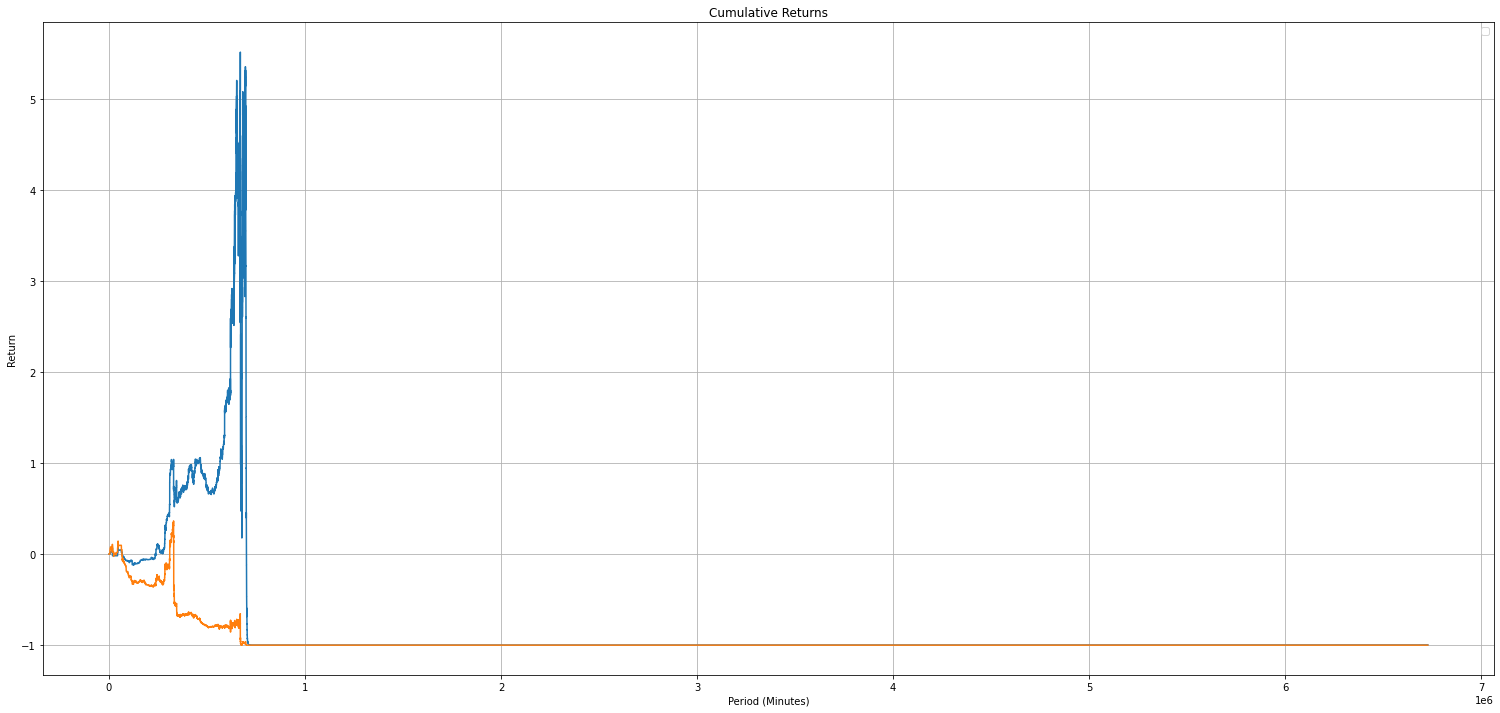

In [ ]:
plt.figure(figsize=(26, 12))
plt.plot(df_org['cum_rets1'])
plt.plot(df_org['cum_price_rets1'])
plt.title("Cumulative Returns")
plt.xlabel("Period (Minutes)")
plt.ylabel("Return")
plt.legend('Strategy Return', 'Price Return')
plt.grid(True)
plt.show()

Here we see a visualization of our returns, which is aligned with what we would expect, the signal may be effective in the shorter term, due to chance and favorable conditions, but over a long period of time, such as in our case from 2012 to present 2024, the volatility of the market conditions and global conditions will erode the gains, and end at the level truly representative of its effectiveness.

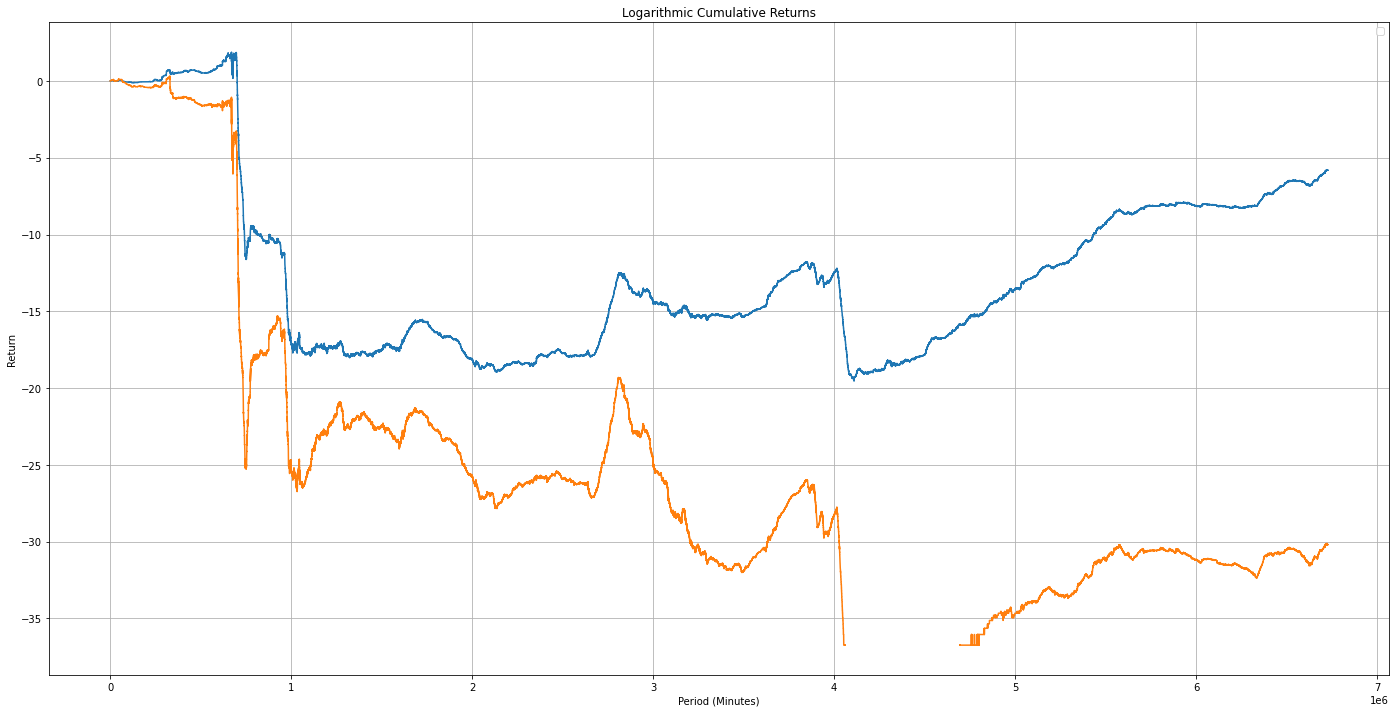

In [ ]:
plt.figure(figsize=(24, 12))
plt.plot(np.log1p(df_org['cum_rets1']))
plt.plot(np.log1p(df_org['cum_price_rets1']))
plt.title("Logarithmic Cumulative Returns")
plt.legend('Strategy', 'Price')
plt.xlabel("Period (Minutes)")
plt.ylabel("Return")
plt.grid(True)
plt.show()

Here we see the logarithmic returns which enhances the readiblity and the insights one is able to get from the previous chart

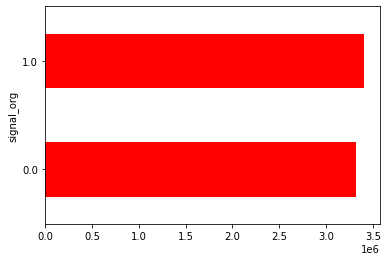

1.0    3403791
0.0    3322489
Name: signal_org, dtype: int64

In [ ]:
fig = plt.figure()
plot = df_org.groupby(['signal_org']).size().plot(kind='barh', color='red')
plt.show()
df_org['signal_org'].value_counts()

We see the split between buy at sell signals, 0 --> sell, 1--> buy

In [ ]:
print("Total Signals:",df_org['signal_org'].value_counts().sum())
df_org['signal_org'].value_counts()*100 / df_org['signal_org'].value_counts().sum()

Total Signals: 6726280


1.0    50.604361
0.0    49.395639
Name: signal_org, dtype: float64

Percentage breakdown of signals, very evenly balanced which is good for ML classification, but as shown above has not produced satisfactory results for returns.

In [ ]:
# Now that we see how poorly the orginal signal trading strat is we will try to improve drastically.

In [ ]:
#The Percentage returns between period i to period i+10
df['ret10'] = df['Close'].pct_change(10)

In [ ]:
def VIX(df, n):
    """
    VIX indicator measures market volatility by calculating the rolling standard deviation of price returns.
    In this implementation, it's adapted to minute-level data by annualizing the standard deviation.
    """
    returns = df['Close'].pct_change()
    VIX = returns.rolling(window = n).std()
    VIX = VIX * np.sqrt(1440 * 365)
    VIX.fillna(0, inplace=True)
    VIX = VIX * 100

    return VIX

df['VIX10'] = VIX(df, 10)
df['VIX30'] = VIX(df, 30)
df['VIX200'] = VIX(df, 200)

In [ ]:
# Moving Average Convergence Divergence
# Momentum Oscillator showing relationship between 2 MAs of bitcoin's price
df['MACD'] = ta.trend.macd_diff(df['Close'])
df['MACD_Sig'] = ta.trend.macd_signal(df['Close'])
print("NaN count in MACD:", df['MACD'].isna().sum())
print('NaN count in MACD Signal:', df['MACD_Sig'].isna().sum())

NaN count in MACD: 33
NaN count in MACD Signal: 33


In [ ]:
from ta.volatility import AverageTrueRange
# Average True Range
# Volatility Measure showing the degree of price movements
# TR is the maximum of the following:
# Current High minus Current Low
# Absolute value of Current High minus Previous Close
# Absolute value of Current Low minus Previous Close
# ATR is the Exponential Moving Average (EMA) of the True Range over the specified window.
# Provides a smoothed measure of volatility
atr_indicator = AverageTrueRange(high = df['High'], low = df['Low'], close = df['Close'], window = 28)
df['ATR'] = atr_indicator.average_true_range()
atr_nan_count = df['ATR'].isna().sum()
print("NaN count in ATR:", atr_nan_count)

NaN count in ATR: 0


In [ ]:
# Kaufman Adaptive Moving Average https://devexperts.com/dxcharts/kb/docs/kaufman-adaptive-moving-average-kama
# Its a MA that adapts to market volatility, reducing lag during strong trends and minimizes major ups and downs
# during constant/sideways price movements
# Efficiency Ratio (ER) Calculation:
# Numerator: The absolute price change over `n` periods.
# Denominator: The sum of absolute daily price changes over `n` periods.
# ER = Numerator / Denominator: Measures the trend's strength. ER approaches 1 in strong trends and 0 in sideways markets.
# Smoothing Constant (SC) Calculation:
# Fast SC: Based on `pow1`, determines how responsive KAMA is during strong trends.
# Slow SC: Based on `pow2`, ensures KAMA doesn't react too quickly during volatile or sideways markets.
# SC = (ER * (fast - slow) + slow)^2: Adapts the smoothing factor based on ER.
# KAMA Calculation:
# Initialization: The first KAMA value is set to the first price.
# Recursive Calculation: Each subsequent KAMA value is the previous KAMA plus SC times the price change
def KAMA(df, n=30, pow1=4, pow2=20):
    price = df['Close']
    change = price - price.shift(n)
    volatility = price.diff().abs().rolling(n, min_periods = 1).sum()

    volatility = volatility.replace(0, np.nan)
    ER = abs(change) / volatility
    ER = ER.fillna(0)

    fast = 2.0 / (pow1 + 1)
    slow = 2.0 / (pow2 + 1)
    SC = (ER * (fast - slow) + slow) ** 2

    kama = np.full(len(price), np.nan)
    first_valid_index = SC.first_valid_index()

    if first_valid_index is not None:
        kama[first_valid_index] = price.iloc[first_valid_index]

        price_diff = price - pd.Series(kama).shift(1)

        valid_mask = ~np.isnan(SC)
        valid_indices = np.where(valid_mask)[0][1:]

        for idx in valid_indices:
            kama[idx] = kama[idx - 1] + SC.iloc[idx] * (price.iloc[idx] - kama[idx - 1])

    return pd.Series(kama, index=df.index)

df['KAMA'] = KAMA(df, n = 30)
print("NaN count in KAMA:", df['KAMA'].isna().sum())

NaN count in KAMA: 0


In [ ]:
# Adaptive Kalman Trend
# Uses Kalman filtering to identify trends while adapting to market volatility
# How It Works:
# Initialization:
# Process Variance (Q): Determines the expected change in the state (trend). Lower Q makes the filter trust its predictions more.
# Measurement Variance (R): Determines the trust in the measurements (actual prices). Lower R makes the filter trust the measurements more.
# Estimates: Array to store the trend estimates.
# Covariance (P): Error covariance indicating the uncertainty of the estimates.
# Kalman Gain (K): Determines the weight given to new measurements.
# Recursive Filtering:
# Prediction Step: Estimate the next state (trend) and update the covariance.
# Update Step: Incorporate the new measurement (price) to refine the estimate and update the Kalman Gain.
# Adaptive Adjustment: Modify the measurement variance (R) based on the recent volatility calculated over the specified window. Higher volatility increases R, making the filter less sensitive to new measurements during turbulent periods
def adaptive_kalman_trend(df, window = 60):
    close_prices = df['Close'].values
    n = len(close_prices)

    # Initialize Kalman filter parameters
    Q = 1e-5  # Process variance
    R = 0.1   # Measurement variance

    estimates = np.zeros(n)
    P = np.ones(n)  # Estimation error covariance
    K = np.zeros(n) # Kalman gain

    estimates[0] = close_prices[0]

    for i in range(1, n):
        P[i] = P[i - 1] + Q
        K[i] = P[i] / (P[i] + R)
        estimates[i] = estimates[i - 1] + K[i] * (close_prices[i] - estimates[i - 1])
        P[i] = (1 - K[i]) * P[i]

        if i >= window:
            R = np.std(close_prices[i - window:i]) * 0.1

    return pd.Series(estimates, index = df.index)

df['AKF'] = adaptive_kalman_trend(df)
df['AKF1'] = df['AKF'].diff()
print("NaN count in AKF:", df['AKF'].isna().sum())

NaN count in AKF: 0


In [ ]:
# Hull Moving Average - highly responsive moving average that reduces lag while maintaining smoothness
# Utilizes weighted moving averages (WMA)
# How It Works:
# Weighted Moving Averages (WMA) Calculation:
# Half Period WMA: WMA over `half_period = period / 2`.
# Full Period WMA: WMA over `period`.
# Raw HMA Calculation: `2 * WMA(half_period) - WMA(period)`.
# Final HMA Calculation:
# Apply a WMA over `sqrt_period = sqrt(period)` to the Raw HMA to obtain the final Hull Moving Average.

def hull_moving_average(df, period = 60):

    half_period = int(period / 2)
    sqrt_period = int(np.sqrt(period))

    weights_half = np.arange(1, half_period + 1)
    weights_full = np.arange(1, period + 1)

    wma_half = np.convolve(df['Close'], weights_half, 'valid') / np.sum(weights_half)
    wma_half = np.concatenate([np.full(half_period - 1, np.nan), wma_half])

    wma_full = np.convolve(df['Close'], weights_full, 'valid') / np.sum(weights_full)
    wma_full = np.concatenate([np.full(period - 1, np.nan), wma_full])

    raw_hma = 2 * wma_half - wma_full

    weights_sqrt = np.arange(1, sqrt_period + 1)
    hma = np.convolve(raw_hma, weights_sqrt, 'valid') / np.sum(weights_sqrt)
    hma = np.concatenate([np.full(sqrt_period - 1, np.nan), hma])

    return pd.Series(hma, index=df.index)

df['HMA'] = hull_moving_average(df)
df['HMA10'] = df['HMA'].shift(10)
df['HMA1'] = df['HMA'].diff()
print("NaN count in HMA:", df['HMA'].isna().sum())
print("NaN count in HMA10:", df['HMA10'].isna().sum())

NaN count in HMA: 65
NaN count in HMA10: 75


In [ ]:
# Calculation of liquidity indicator
def Liquidity(df, n):
    """
    The Liquidity Indicator measures the average dollar liquidity of an asset over a specified window,
    providing insights into the asset's trading activity and ease of buying or selling without affecting its price.
    """
    dollar_liquidity = (df['Volume'] * df['WTD_Price']).rolling(window = n, min_periods = 1).mean()
    dollar_liquidity = dollar_liquidity.fillna(0)

    return dollar_liquidity

df['LQD20'] = Liquidity(df, 20)
df['LQD60'] = Liquidity(df, 60)
df['LQD200'] = Liquidity(df, 200)

In [ ]:
# Ehlers Cycle Measure
def ehlers_cycle(close, alpha = 0.07):
    coeff1 = alpha - (alpha ** 2) / 4
    coeff2 = 0.5 * alpha ** 2
    coeff3 = - (alpha - 0.75 * alpha ** 2)
    coeff4 = 2 * (1 - alpha)
    coeff5 = - (1 - alpha) ** 2

    close = df['Close']
    n = len(close)
    smooth = pd.Series(np.zeros(n), index = df.index)
    cycle = pd.Series(np.zeros(n), index = df.index)

    smooth.iloc[:7] = close.iloc[:7]
    cycle.iloc[:7] = 0

    close_lag1 = close.shift(1)
    close_lag2 = close.shift(2)
    smooth_lag1 = smooth.shift(1)
    smooth_lag2 = smooth.shift(2)

    smooth.iloc[7:] = (
      coeff1 * close.iloc[7:] +
      coeff2 * close_lag1.iloc[7:] +
      coeff3 * close_lag2.iloc[7:] +
      coeff4 * smooth_lag1.iloc[7:] +
      coeff5 * smooth_lag2.iloc[7:]
    )

    cycle_lag1 = cycle.shift(1)
    cycle_lag2 = cycle.shift(2)

    cycle.iloc[7:] = (
      (close.iloc[7:] - 2 * close_lag1.iloc[7:] + close_lag2.iloc[7:]) / 4 +
      2 * cycle_lag1.iloc[7:] -
      cycle_lag2.iloc[7:]
    )

    return cycle

df['Ehlrs_CYC'] = ehlers_cycle(df)
df['Ehlrs_CYC1'] = df['Ehlrs_CYC'].diff()
print("NaN count in ehlers_cycle:", df['Ehlrs_CYC'].isna().sum())

NaN count in ehlers_cycle: 0


Due to Moving average features usually using lags and rolling calculations for their calculations, inevitably, depending on the period - n desired for the moving average, a proportional amount of inital rows will need to be dropped after as these rows will be NaN due to no data being present until the minimum number of periods is available.

For reference in this reaserch project, when we refer to a period we are always referring to minutes

In [ ]:
print(df.shape)
nan_vals = df.isnull().values.any()
nan_vals

(6726280, 27)


True

In [ ]:
df.isnull().sum()

Open           0
High           0
Low            0
Close          0
Volume         0
WTD_Price      0
short_mavg     0
long_mavg      0
signal_org     0
ret10         10
VIX10          0
VIX30          0
VIX200         0
MACD          33
MACD_Sig      33
ATR            0
KAMA           0
AKF            0
AKF1           1
HMA           65
HMA10         75
HMA1          66
LQD20          0
LQD60          0
LQD200         0
Ehlrs_CYC      0
Ehlrs_CYC1     1
dtype: int64

In [ ]:
df = df.dropna()
df.isnull().sum().values.any()

False

In [ ]:
set_option('display.width', 100)
df.tail(3)

,Open,High,Low,Close,Volume,WTD_Price,short_mavg,long_mavg,signal_org,ret10,...,AKF,AKF1,HMA,HMA10,HMA1,LQD20,LQD60,LQD200,Ehlrs_CYC,Ehlrs_CYC1
6726277,97430.0,97450.0,97429.0,97450.0,0.001500,97439.75,97428.7,97332.183333,1.0,0.000277,...,98861.097210,-0.975330,97571.937011,97652.167406,0.241577,6579.101093,110585.555213,383563.815364,-17.5,-14.0
6726278,97462.0,97487.0,97462.0,97468.0,0.023377,97469.75,97433.1,97339.433333,1.0,0.000452,...,98860.131739,-0.965471,97570.731125,97634.481908,-1.205886,6676.474381,107466.416060,383520.104520,18.5,36.0
6726279,97318.0,97340.0,97277.0,97340.0,0.003834,97318.75,97427.3,97345.916667,1.0,-0.000595,...,98859.050020,-1.081719,97566.367671,97619.017204,-4.363453,6640.939895,106919.183762,383312.308335,-36.5,-55.0


After dropping the NaN rows, we investigate the data to ensure that the statistics of each feature is aligned with what would be expected thus no obvious calculation errors are present and then we take a snapshot of a random sample of the data to investigate further to confirm what the feature statistics show.

Now after creating these additional columns of data - features, we will implement a novel weighting and combination mechanism to maximize the returns these features/indicators can generate. This is done by first optimzing the signals creates as they directly affect our returns.


We split our signals into 5 types: Trend, Momentum, Cycle, Volume and Volatility. Each of these will have the indicator used to generate them weighted. The weightings will always be equal to 1 and is based on estimations/assumptions and research.

Each indicator is a comparison of 1 or more features or a comparison to a known value. If a positive condition is realised, a 1 is attributed while if a negative conditon found, a 0 will be attributed. Its these values which are weighted to make up the values for each signal type

After this we will compile the types of signals strengths with the weight for each.

This again we are uncertain what the optimal combination is thus we will speak more on our optimisation process below.

Now that we have our composite signals which will all have a value between 0 and 1, we need to have a threshold for which when the value of the compsite signal crosses, this shows a positive enough sentiment to signal the trader to purchase.

In addition to just a base threshold, we made it dynamic by having a scale/adjust based on the volatility seen in the market, which is key to try reduce risk of losses.

Again we are uncertain what the values for these factors should be thus we will optimise it based on a parameter grid having 100s of combinations of weights and values, to arrive at the combination which maximizes the returns and sharpe.


This final optimial combination will then be used to conduct the ML classification analysis on.

In [ ]:
def signal_generator(df, weights=None, base_threshold=0.2, volatility_adjustment=0.1):
    """
    Trading signals based on multiple technical indicators

    Parameters:
    weights (dict): Dictionary of weights for different signals
    base_threshold (float): Base threshold for signal generation
    volatility_adjustment (float): Adjustment factor for volatility
    """
    if weights is None:
        weights = {
          'trend': 0.40,
          'momentum': 0.25,
          'volume': 0.20,
          'volatility': 0.10,
          'cycle': 0.05
      }

    signals = pd.DataFrame(index=df.index)

    # Trend Signals
    hma_trend = (
      0.5 * np.where(df['Close'] > df['HMA'], 1, 0) +   # Price above HMA
      0.3 * np.where(df['HMA1'] > 0, 1, 0) +            # HMA slope
      0.2 * np.where(df['HMA'] > df['HMA10'], 1, 0)     # HMA trend
    )

    akf_trend = (
      0.65 * np.where(df['Close'] > df['AKF'], 1, 0) +  # Price above AKF
      0.35 * np.where(df['AKF1'] > 0, 1, 0))            # AKF slope

    kama_trend = np.where(df['Close'] > df['KAMA'], 1, 0)

    signals['trend'] = np.clip((
      0.45 * hma_trend +    # HMA high weight --> noise reduc.
      0.45 * akf_trend +    # AKF weight --> adaptive trend
      0.1 * kama_trend     # KAMA weight --> conf. ind.
    ), 0, 1)

    # Momentum Signals
    signals['momentum'] = np.clip((
      0.8 * np.where(df['MACD'] > df['MACD_Sig'], 1, 0) +
      0.2 * np.where(df['ret10'] > 0, 1, 0)
    ),0, 1)

    # Volume Signals
    signals['volume'] = np.clip((
      0.6 * np.where(df['LQD20'] > df['LQD60'], 1, 0) +
      0.4 * np.where(df['LQD60'] > df['LQD200'] * 1.2, 1, 0)
    ), 0, 1)

    # Volatility Signals
    signals['volatility'] = np.clip((
      0.2 * np.where(df['VIX30'] < df['VIX30'].rolling(window = 30, min_periods = 1).mean(), 1, 0) +
      0.6 * np.where(df['ATR'] < df['ATR'].rolling(window = 20, min_periods = 1).mean(), 1, 0) +
      0.2 * np.where(df['VIX10'] < df['VIX30'], 1, 0)
    ), 0, 1)

    # Cycle Signals
    signals['cycle'] = np.clip(np.where(
      (df['Ehlrs_CYC'] > 0) & (df['Ehlrs_CYC1'] > 0), 1, 0
    ), 0, 1)

    composite_signal = np.clip((
      weights['trend'] * signals['trend'] +
      weights['momentum'] * signals['momentum'] +
      weights['volume'] * signals['volume'] +
      weights['volatility'] * signals['volatility'] +
      weights['cycle'] * signals['cycle']
    ), 0, 1)

    dynamic_threshold = base_threshold + volatility_adjustment * (
      df['VIX30'] / df['VIX30'].rolling(window = 100, min_periods = 1).mean() - 1
    )

    return (composite_signal > dynamic_threshold).astype(int)

In [ ]:
def evaluate_strategy(df, weights, base_threshold, volatility_adjustment):
    """
    Trading strategy performance using multiple metrics:
    - Sharpe Ratio: Risk-adjusted returns
    - Maximum Drawdown: Worst peak-to-trough decline
    -
    - Win Rate: Percentage of profitable trades

    Returns a composite score weighted by the importance of each metric.
    """
    df['signal_adv'] = signal_generator(df = df,
      weights = weights,
      base_threshold = base_threshold,
      volatility_adjustment = volatility_adjustment
    )

    signals = df['signal_adv']
    annualization_factor = np.sqrt(1440 * 385)

    execution_price = df['Open'].shift(-1).fillna(0)
    exit_price = df['Close'].shift(-1).fillna(0)
    price_rets = (exit_price - execution_price) / execution_price
    price_rets = price_rets.fillna(0)

    cum_price_rets = (1 + price_rets).cumprod() - 1
    strategy_rets = price_rets * signals
    strategy_rets = strategy_rets.dropna()

    # Sharpe Ratio (annualized)
    annualized_sharpe = (annualization_factor * strategy_rets.mean()) / (strategy_rets.std())

    # Maximum Drawdown
    cum_rets = (1 + strategy_rets).cumprod() - 1
    rolling_max = cum_rets.expanding().max()
    epsilon = 1e-12
    rolling_max = rolling_max.replace(0, epsilon)
    DD = cum_rets / rolling_max - 1
    DD = DD.replace([np.inf, -np.inf], np.nan)
    max_DD = DD.min()

    # Win Rate
    signal_changes = signals.diff().fillna(0)
    trade_points = signal_changes != 0
    trade_num = trade_points.cumsum()
    trade_rets = strategy_rets[trade_points]
    winning_trades = (trade_rets > 0).sum()
    total_trades = len(trade_rets)
    win_rate = winning_trades / total_trades if total_trades > 0 else 0

    # Sortino Ratio - Risk-Adjusted Returns
    negative_rets = strategy_rets[strategy_rets < 0]
    downside_std = negative_rets.std()
    sortino_ratio = annualization_factor * strategy_rets.mean()/ (downside_std if downside_std != 0 else float('inf'))

    # Average Return per Trade
    avg_return_per_trade = strategy_rets.mean() * 100

    # CAGR - compound annual growth rate
    cagr = (1 + cum_rets.iloc[-1]) ** ( 1440 * 365 / len(cum_rets)) - 1

    # Composite Score
    composite_score = (
      0.6 * (annualized_sharpe) +
      0.4 * cum_rets.iloc[-1]
    )

    return composite_score, annualized_sharpe, win_rate, avg_return_per_trade, cum_rets.iloc[-1], cagr, max_DD

In [ ]:
param_grid = {
    'weights': [
        {'trend': 0.35, 'momentum': 0.30, 'volume': 0.10, 'volatility': 0.10, 'cycle': 0.15},
        {'trend': 0.35, 'momentum': 0.30, 'volume': 0.05, 'volatility': 0.10, 'cycle': 0.20},
        {'trend': 0.35, 'momentum': 0.30, 'volume': 0.10, 'volatility': 0.05, 'cycle': 0.20},
        {'trend': 0.35, 'momentum': 0.35, 'volume': 0.10, 'volatility': 0.05, 'cycle': 0.25},
        {'trend': 0.30, 'momentum': 0.30, 'volume': 0.20, 'volatility': 0.10, 'cycle': 0.10}
    ],
    'base_threshold': [0.58584, 0.585845],
    'volatility_adjustment': [0.19]
}
"""
param_grid = {
    'weights': [
        {'trend': 0.35, 'momentum': 0.25, 'volume': 0.15, 'volatility': 0.15, 'cycle': 0.10},
        {'trend': 0.40, 'momentum': 0.30, 'volume': 0.10, 'volatility': 0.10, 'cycle': 0.10},
        {'trend': 0.35, 'momentum': 0.30, 'volume': 0.10, 'volatility': 0.20, 'cycle': 0.05},
        {'trend': 0.45, 'momentum': 0.25, 'volume': 0.15, 'volatility': 0.10, 'cycle': 0.05},
        {'trend': 0.25, 'momentum': 0.35, 'volume': 0.15, 'volatility': 0.15, 'cycle': 0.10},
        {'trend': 0.30, 'momentum': 0.30, 'volume': 0.20, 'volatility': 0.10, 'cycle': 0.10}
    ],
    'base_threshold': [0.5858, 0.58585, 0.585875, 0.5859 , 0.58595, 0.586, 0.5861],
    'volatility_adjustment': [0.175, 0.19, 0.2, 0.21]


    'weights': [
        {'trend': 0.35, 'momentum': 0.25, 'volume': 0.15, 'volatility': 0.15, 'cycle': 0.10},
        {'trend': 0.40, 'momentum': 0.30, 'volume': 0.10, 'volatility': 0.10, 'cycle': 0.10},
        {'trend': 0.35, 'momentum': 0.30, 'volume': 0.10, 'volatility': 0.20, 'cycle': 0.05},
        {'trend': 0.35, 'momentum': 0.30, 'volume': 0.15, 'volatility': 0.15, 'cycle': 0.05},
        {'trend': 0.35, 'momentum': 0.25, 'volume': 0.10, 'volatility': 0.20, 'cycle': 0.10},
        {'trend': 0.35, 'momentum': 0.25, 'volume': 0.20, 'volatility': 0.10, 'cycle': 0.10},
        {'trend': 0.35, 'momentum': 0.30, 'volume': 0.20, 'volatility': 0.10, 'cycle': 0.05},
        {'trend': 0.35, 'momentum': 0.30, 'volume': 0.10, 'volatility': 0.10, 'cycle': 0.15},
        {'trend': 0.35, 'momentum': 0.30, 'volume': 0.05, 'volatility': 0.10, 'cycle': 0.20},
        {'trend': 0.35, 'momentum': 0.30, 'volume': 0.10, 'volatility': 0.05, 'cycle': 0.20},
        {'trend': 0.35, 'momentum': 0.35, 'volume': 0.10, 'volatility': 0.05, 'cycle': 0.25},
        {'trend': 0.30, 'momentum': 0.30, 'volume': 0.20, 'volatility': 0.10, 'cycle': 0.10}
    ],
    'base_threshold': [0.58583, 0.58584, 0.585845, 0.58585, 0.58586, 0.58587, 0.585875, 0.58588, 0.58589],
    'volatility_adjustment': [0.18, 0.19, 0.2, 0.21]
}
"""
def optimize_parameters(param_grid):
    """
    Optimize strategy parameters using grid search

    Parameters:
    param_grid (dict): Dictionary containing parameter combinations to test

    Returns:
    dict: Best performing parameters and their performance metrics
    """
    best_performance = float('-inf')
    best_params = None
    all_results = []

    total_combinations = (
      len(param_grid['weights']) *
      len(param_grid['base_threshold']) *
      len(param_grid['volatility_adjustment'])
    )
    print(f"Testing {total_combinations} parameter combinations...")

    for weights in param_grid['weights']:
        for base_thresh in param_grid['base_threshold']:
            for vol_adj in param_grid['volatility_adjustment']:
                print(f'Perf Eval: {weights}, {base_thresh}, {vol_adj}')

                performance, sharpe, wins, avg_ret, cum_ret, cagr, max_DD = evaluate_strategy(df = df,
                    weights = weights,
                    base_threshold = base_thresh,
                    volatility_adjustment = vol_adj
                )

                result = {
                    'weights': weights,
                    'base_threshold': base_thresh,
                    'volatility_adjustment': vol_adj,
                    'performance': performance,
                    'sharpe': sharpe,
                    'win_rate': wins,
                    'avg_ret_per_trade': avg_ret,
                    'cum_ret': cum_ret,
                    'cagr': cagr,
                    'max_DD': max_DD
                }
                all_results.append(result)

                if performance > best_performance:
                    best_performance = performance
                    best_params = result.copy()

    all_results.sort(key = lambda x: x['performance'], reverse = True)

    return {
      'best_params': best_params,
      'all_results': all_results[:10],
      'total_tested': total_combinations
  }

def run_optimization():
    """
    Run the optimization process and display results
    """
    print("Starting parameter optimization...")
    results = optimize_parameters(param_grid)

    print("\nOptimization Results:")
    print("====================")
    print(f"Best Parameters Found:")
    print(f"Weights: {results['best_params']['weights']}")
    print(f"Base Threshold: {results['best_params']['base_threshold']}")
    print(f"Volatility Adjustment: {results['best_params']['volatility_adjustment']}")
    print(f"Performance Score: {results['best_params']['performance']:.1f}")
    print(f"Sharpe: {results['best_params']['sharpe']:.3f}")
    print(f"Win Rate: {results['best_params']['win_rate']:.3f}")
    print(f"Avg Returns per trade: {results['best_params']['avg_ret_per_trade']:.4f}")
    print(f"Cumulative Returns: {results['best_params']['cum_ret']:.1f}")
    print(f"CAGR: {results['best_params']['cagr']:.3f}")
    print(f"Max Drawdown: {results['best_params']['max_DD']:.1f}")

    print("\nTop 10 Parameter Combinations:")
    for i, result in enumerate(results['all_results'], 1):
        print(f"{i} Weights: {result['weights']}")
        print(f"{i} Base Threshold: {result['base_threshold']}")
        print(f"{i} Volatility Adjustment: {result['volatility_adjustment']}")
        print(f"  {i}. Performance Score: {result['performance']:.1f}")
        print(f"  {i}. Sharpe: {result['sharpe']:.3f}")
        print(f"  {i}. Win Rate: {result['win_rate']:.3f}")
        print(f"  {i}. Avg Returns per trade: {result['avg_ret_per_trade']:.4f}")
        print(f"  {i}. Cumulative Return: {result['cum_ret']:.1f}")
        print(f"  {i}. CAGR: {result['cagr']:.3f}")
        print(f"  {i}. Max DrawDown: {result['max_DD']:.1f}")

    return results['best_params']

best_params = run_optimization()

Starting parameter optimization...
Testing 10 parameter combinations...
Perf Eval: {'trend': 0.35, 'momentum': 0.3, 'volume': 0.1, 'volatility': 0.1, 'cycle': 0.15}, 0.58584, 0.19
Perf Eval: {'trend': 0.35, 'momentum': 0.3, 'volume': 0.1, 'volatility': 0.1, 'cycle': 0.15}, 0.585845, 0.19
Perf Eval: {'trend': 0.35, 'momentum': 0.3, 'volume': 0.05, 'volatility': 0.1, 'cycle': 0.2}, 0.58584, 0.19
Perf Eval: {'trend': 0.35, 'momentum': 0.3, 'volume': 0.05, 'volatility': 0.1, 'cycle': 0.2}, 0.585845, 0.19
Perf Eval: {'trend': 0.35, 'momentum': 0.3, 'volume': 0.1, 'volatility': 0.05, 'cycle': 0.2}, 0.58584, 0.19
Perf Eval: {'trend': 0.35, 'momentum': 0.3, 'volume': 0.1, 'volatility': 0.05, 'cycle': 0.2}, 0.585845, 0.19
Perf Eval: {'trend': 0.35, 'momentum': 0.35, 'volume': 0.1, 'volatility': 0.05, 'cycle': 0.25}, 0.58584, 0.19
Perf Eval: {'trend': 0.35, 'momentum': 0.35, 'volume': 0.1, 'volatility': 0.05, 'cycle': 0.25}, 0.585845, 0.19
Perf Eval: {'trend': 0.3, 'momentum': 0.3, 'volume': 0.2

In [ ]:
weights = {
          'trend': 0.35,      # Increased due to enhanced trend signals
          'momentum': 0.30,   # Momentum confirms trend
          'volume': 0.10,     # Volume validates moves
          'volatility': 0.10, # Reduced slightly to give more weight to trend
          'cycle': 0.15       # Cycle timing for entry/exit
      }

df['signal_adv'] = signal_generator(df, weights = weights, base_threshold = 0.585845, volatility_adjustment = 0.19)

In [ ]:
df_org_eval = df.copy()
df_org_eval = df_org_eval.drop(['signal_adv'], axis = 1)
df_org_eval = df_org_eval.rename(columns={'signal_org': 'signal'})

df_adv_eval = df.copy()
df_adv_eval = df_adv_eval.drop(['signal_org'], axis = 1)
df_adv_eval = df_adv_eval.rename(columns={'signal_adv': 'signal'})

In [ ]:
def final_strategy_comp(df):

    df['price_rets'] = ((df['Close'].shift(-1) - df['Open'].shift(-1)) / df['Open'].shift(-1)).fillna(0)
    df['cum_price_rets'] = (1 + df['price_rets']).cumprod()
    df['strat_rets'] = (df['price_rets'] * df['signal']).fillna(0)
    df['cum_rets'] = (1 + df['strat_rets']).cumprod()
    cum_rets = df['cum_rets']

    # CAGR (compound annual growth rate)
    cagr = (1 + df['cum_rets'].iloc[-1])** (1440 * 365 / len(df['cum_rets'])) - 1

    # Sharpe Ratio (annualized)
    annualization_factor = np.sqrt(1440 * 365)
    sharpe =  (annualization_factor * df['strat_rets'].mean()) / (df['strat_rets'].std())

    # Win Rate
    signal_changes = df['signal'].diff().fillna(0)
    trade_points = signal_changes != 0
    trade_num = trade_points.cumsum()
    trade_rets = df.loc[trade_points, 'strat_rets'].dropna()
    winning_trades = (trade_rets > 0).sum()
    total_trades = len(trade_rets)
    win_rate = winning_trades / total_trades if total_trades > 0 else 0

    rolling_max = cum_rets.expanding().max()
    DD = cum_rets / rolling_max - 1
    max_DD = DD.min()

    cum_strat_ret = df['cum_rets'].iloc[-1]
    cum_price_ret = df['cum_price_rets'].iloc[-1]

    print(f'Total Trades: {total_trades}')
    print(f'Winning Trades: {winning_trades}')
    print(f'Win Rate: {win_rate:.4f}')
    print(f'Sharpe: {sharpe:.4f}')
    print(f'CAGR: {cagr:.4f}')
    print(f'Max DrawDown: {max_DD:.4f}')
    print(f'Strategy Total Return: {cum_strat_ret}')
    print('Buy First Open & Hold to Last Close Return:', (df['Close'].iloc[-1] - df['Open'].iloc[0])/df['Open'].iloc[0])
    print(f'Price Total Return: {cum_price_ret}')
    fig = plt.figure()
    plot = df.groupby(['signal']).size().plot(kind='barh', color='red')
    plt.show()
    print(f"Signals Count:{df['signal'].value_counts()}")
    print(f"\nSignals %: {df['signal'].value_counts()*100 / df['signal'].value_counts().sum()}")

    return total_trades, sharpe, win_rate, cagr, max_DD, winning_trades, cum_strat_ret, cum_price_ret, cum_rets


Total Trades: 245067
Winning Trades: 30627
Win Rate: 0.1250
Sharpe: -0.2438
CAGR: 0.0002
Max DrawDown: -1.0000
Strategy Total Return: 0.002977100082180467
Buy First Open & Hold to Last Close Return: 21252.275109170307
Price Total Return: 7.710510052583497e-14


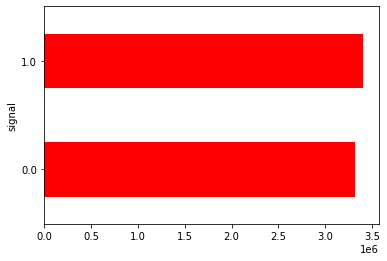

Signals Count:1.0    3403789
0.0    3322416
Name: signal, dtype: int64

Signals %: 1.0    50.604895
0.0    49.395105
Name: signal, dtype: float64


In [ ]:
#Original
org_total_trades, org_sharpe, org_win_rate, org_cagr, org_max_DD, org_winning_trades, org_cum_strat_ret, org_cum_price_ret, org_cum_rets = final_strategy_comp(df_org_eval)

Total Trades: 1513890
Winning Trades: 280637
Win Rate: 0.1854
Sharpe: 2.1832
CAGR: 1.4916
Max DrawDown: -0.9999
Strategy Total Return: 118534.45145246519
Buy First Open & Hold to Last Close Return: 21252.275109170307
Price Total Return: 7.710510052583497e-14


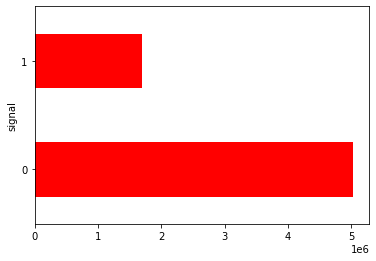

Signals Count:0    5034022
1    1692183
Name: signal, dtype: int64

Signals %: 0    74.841935
1    25.158065
Name: signal, dtype: float64


In [ ]:
#Advanced
adv_total_trades, adv_sharpe, adv_win_rate, adv_cagr, adv_max_DD, adv_winning_trades, adv_cum_strat_ret, adv_cum_price_ret, adv_cum_rets = final_strategy_comp(df_adv_eval)

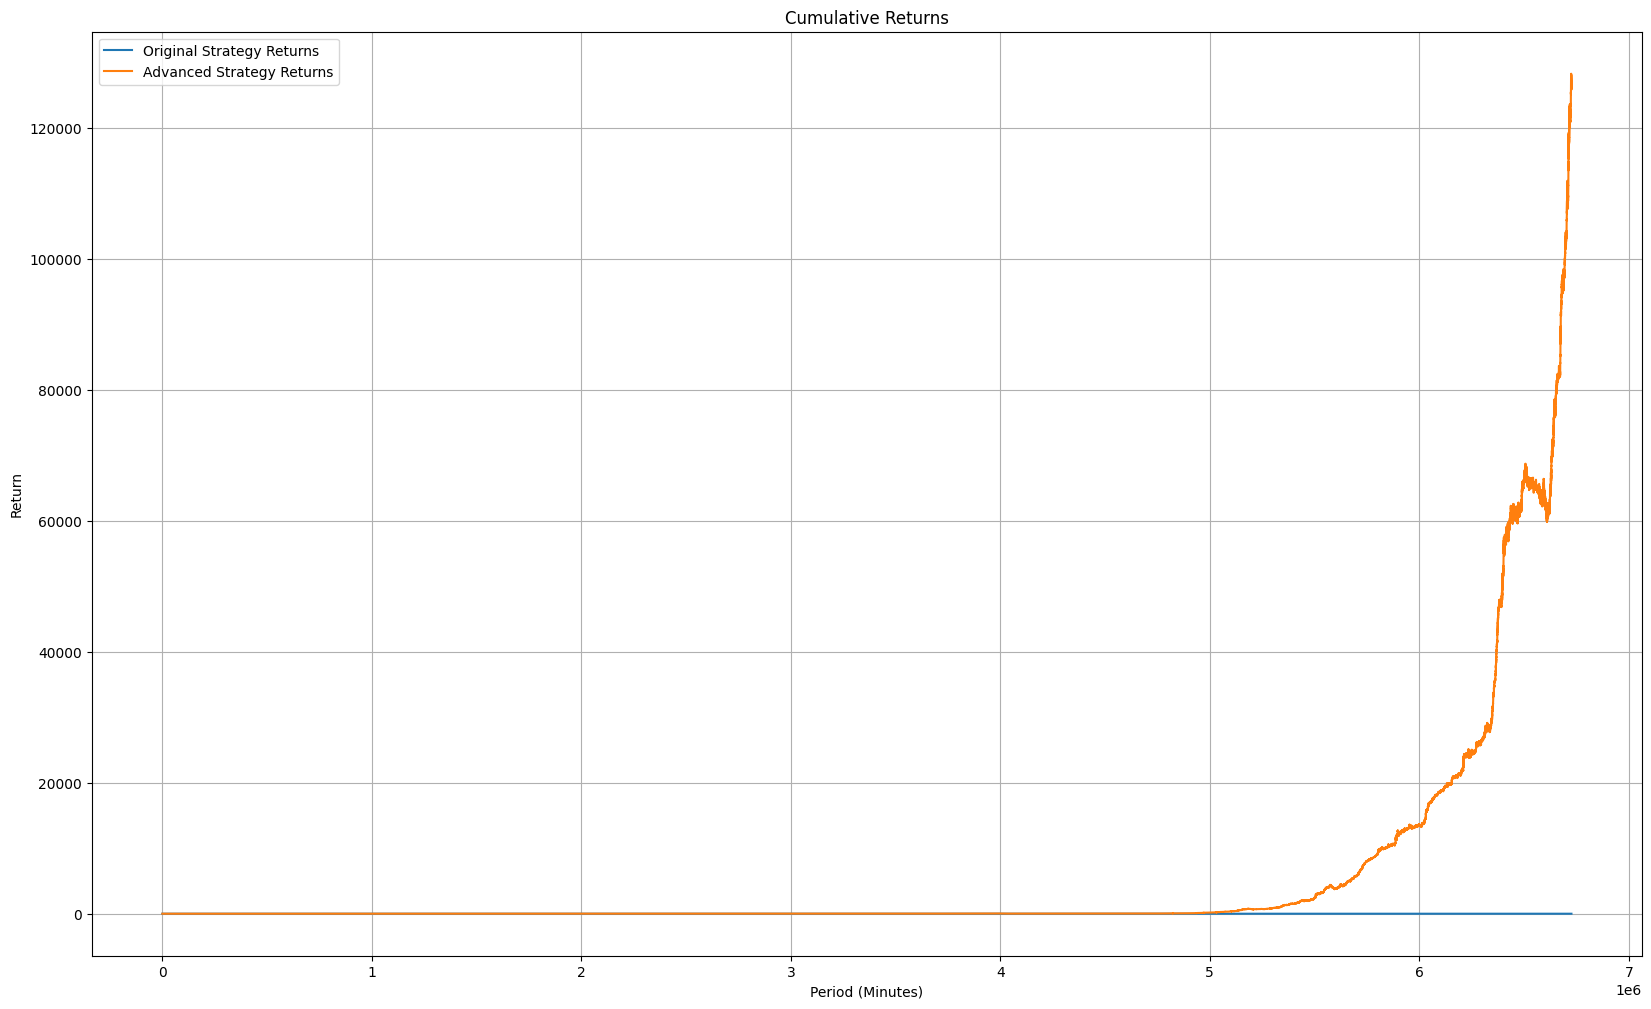

In [ ]:
plt.figure(figsize=(20, 12))
plt.plot(org_cum_rets)
plt.plot(adv_cum_rets)
plt.title("Cumulative Returns")
plt.xlabel("Period (Minutes)")
plt.ylabel("Return")
plt.legend(['Original Strategy Returns', 'Advanced Strategy Returns'])
plt.grid(True)
plt.show()

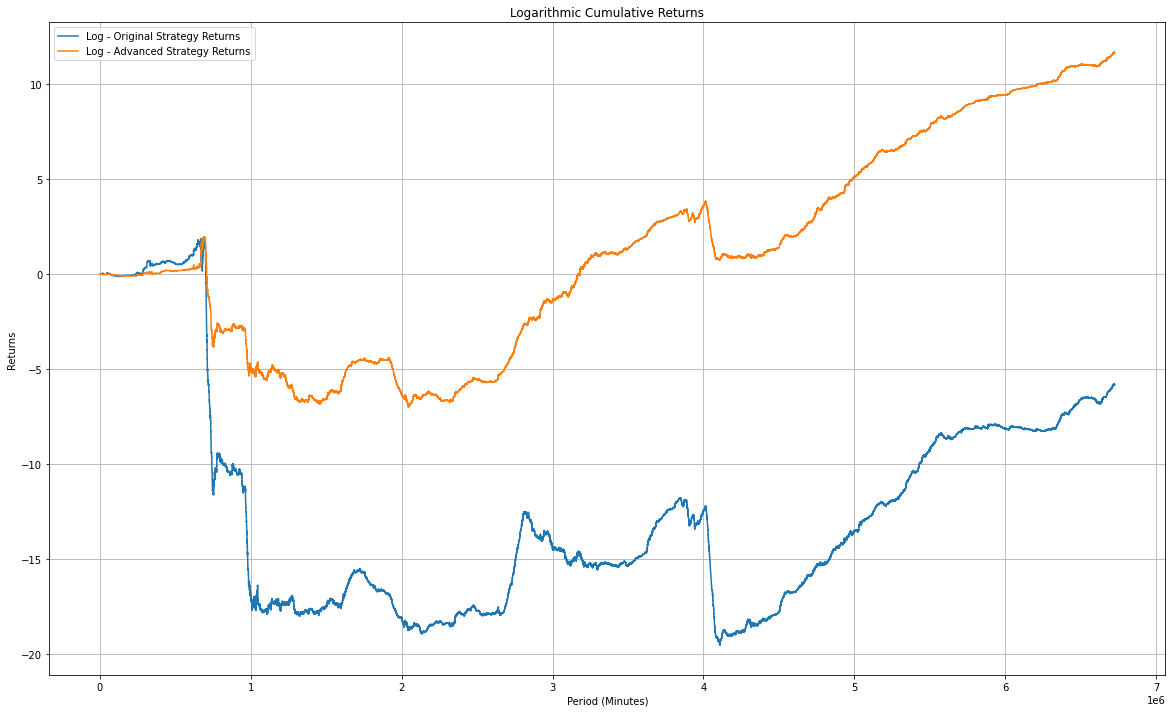

In [ ]:
plt.figure(figsize=(20, 12))
plt.plot(np.log(org_cum_rets))
plt.plot(np.log(adv_cum_rets))
plt.title("Logarithmic Cumulative Returns")
plt.xlabel("Period (Minutes)")
plt.ylabel("Returns")
plt.legend(['Log - Original Strategy Returns', 'Log - Advanced Strategy Returns'])
plt.grid(True)
plt.show()

# 5. Feature Engineering

In [ ]:
#Creating additional features to use for prediciton which wont be dropped

# exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean())

    return EMA

df['EMA10'] = EMA(df, 10)
df['EMA30'] = EMA(df, 30)
df['EMA200'] = EMA(df, 200)

# rate of change
def ROC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    ROC = pd.Series(((M / N) * 100))

    return ROC

df['ROC10'] = ROC(df['Close'], 10)
df['ROC20'] = ROC(df['Close'], 20)
df['ROC30'] = ROC(df['Close'], 30)

# price momentum
def MOM(df, n):

    MOM = pd.Series(df.diff(n))

    return MOM

df['MOM10'] = MOM(df['Close'], 10)
df['MOM20'] = MOM(df['Close'], 20)
df['MOM30'] = MOM(df['Close'], 30)

# relative strength index
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period - 1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period - 1)])
    d[d.index[period - 1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period - 1)])
    rs = u.ewm(com = period - 1, adjust = False).mean() / \
    d.ewm(com = period - 1, adjust = False).mean()

    return 100 - 100 / (1 + rs)

df['RSI10'] = RSI(df['Close'], 10)
df['RSI20'] = RSI(df['Close'], 20)
df['RSI30'] = RSI(df['Close'], 30)
df['RSI100'] = RSI(df['Close'], 100)
df['RSI200'] = RSI(df['Close'], 200)

# stochastic osillator.
def STOK(close, low, high, n):

    STOK = ((close - low.rolling(n, min_periods = 1).min()) / (high.rolling(n, min_periods = 1).max() - low.rolling(n, min_periods = 1).min()).replace(0,1e-10)) * 100

    return STOK

def STOD(close, low, high, n):

    STOK = ((close - low.rolling(n, min_periods = 1).min()) / (high.rolling(n, min_periods = 1).max() - low.rolling(n, min_periods = 1).min()).replace(0,1e-10)) * 100
    STOD = STOK.rolling(3, min_periods = 1).mean()

    return STOD

df['%K10'] = STOK(df['Close'], df['Low'], df['High'], 10)
df['%D10'] = STOD(df['Close'], df['Low'], df['High'], 10)

df['%K20'] = STOK(df['Close'], df['Low'], df['High'], 20)
df['%D20'] = STOD(df['Close'], df['Low'], df['High'], 20)

df['%K30'] = STOK(df['Close'], df['Low'], df['High'], 30)
df['%D30'] = STOD(df['Close'], df['Low'], df['High'], 30)

df['%K60'] = STOK(df['Close'], df['Low'], df['High'], 60)
df['%D60'] = STOD(df['Close'], df['Low'], df['High'], 60)

df['%K200'] = STOK(df['Close'], df['Low'], df['High'], 200)
df['%D200'] = STOD(df['Close'], df['Low'], df['High'], 200)

In [ ]:
print(df.shape)
df.isnull().sum()

(6726205, 52)


Open            0
High            0
Low             0
Close           0
Volume          0
WTD_Price       0
short_mavg      0
long_mavg       0
signal_org      0
ret10           0
VIX10           0
VIX30           0
VIX200          0
MACD            0
MACD_Sig        0
ATR             0
KAMA            0
AKF             0
AKF1            0
HMA             0
HMA10           0
HMA1            0
LQD20           0
LQD60           0
LQD200          0
Ehlrs_CYC       0
Ehlrs_CYC1      0
signal_adv      0
EMA10           9
EMA30          29
EMA200        199
ROC10           9
ROC20          19
ROC30          29
MOM10          10
MOM20          20
MOM30          30
RSI10         552
RSI20         552
RSI30         552
RSI100        552
RSI200        552
%K10            0
%D10            0
%K20            0
%D20            0
%K30            0
%D30            0
%K60            0
%D60            0
%K200           0
%D200           0
dtype: int64

In [ ]:
#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods = 1).mean())

    return MA

df['MA10'] = MA(df, 10)
df['MA30'] = MA(df, 30)
df['MA60'] = MA(df, 60)
df['MA200'] = MA(df, 200)

In [ ]:
# On-Balance Volume
df['OBV'] = ta.volume.on_balance_volume(df['Close'], df['Volume'])
print("NaN count in OBV:", df['OBV'].isna().sum())

NaN count in OBV: 0


In [ ]:
def williams_r(df, n):
    """
    Calculate Williams %R indicator

    Parameters:
    df: DataFrame with High, Low, Close columns
    period: Lookback period

    Returns:
    Series containing Williams %R values
    """
    highest_high = df['High'].rolling(window = n, min_periods = 1).max()
    lowest_low = df['Low'].rolling(window = n, min_periods = 1).min()


    wr = ((highest_high - df['Close']) / (highest_high - lowest_low ) * -100)
    wr = wr.replace([np.inf, -np.inf], None)
    wr = wr.replace({np.nan: None}).ffill()

    return wr

df['Will_R10'] = williams_r(df, 10)
df['Will_R20'] = williams_r(df, 20)
df['Will_R60'] = williams_r(df, 60)
print("NaN count in Williams r 10:", df['Will_R10'].isna().sum())
print("NaN count in Williams r 20:", df['Will_R20'].isna().sum())
print("NaN count in Williams r 60:", df['Will_R60'].isna().sum())

NaN count in Williams r 10: 552
NaN count in Williams r 20: 552
NaN count in Williams r 60: 552


In [ ]:
df['Will_MA10'] = df['Will_R20'].rolling(window = 10, min_periods = 1).mean()
df['Will_MA20'] = df['Will_R20'].rolling(window = 20, min_periods = 1).mean()
df['Will_MA60'] = df['Will_R20'].rolling(window = 60, min_periods = 1).mean()
print("NaN count in Williams MA10:", df['Will_MA10'].isna().sum())
print("NaN count in Williams MA20:", df['Will_MA20'].isna().sum())
print("NaN count in Williams MA60:", df['Will_MA20'].isna().sum())

NaN count in Williams MA10: 552
NaN count in Williams MA20: 552
NaN count in Williams MA60: 552


In [ ]:
# Accumulation/Distribution Indicator (A/D) https://www.investopedia.com/terms/a/accumulationdistribution.asp
def accumulation_distribution(df):
    """
    Compute the Accumulation/Distribution Line.
    A/D Line = cumulative sum of Money Flow Volume,
    where Money Flow Multiplier = ((Close - Low) - (High - Close)) / (High - Low)
    and Money Flow Volume = Money Flow Multiplier * Volume
    """
    high = df['High']
    low = df['Low']
    close = df['Close']
    volume = df['Volume']

    range_ = (high - low)
    zero_range_mask = (range_ == 0)

    mfm = ((close - low) - (high - close)) / range_
    mfm = mfm.mask(zero_range_mask, 0)
    mfv = mfm * volume

    ad_line = mfv.cumsum()

    return ad_line

df['AD_Lin'] = accumulation_distribution(df)
print("NaN count in AD_Line:", df['AD_Lin'].isna().sum())

NaN count in AD_Line: 0


In [ ]:
# Fisher Transform of RSI https://www.investopedia.com/terms/f/fisher-transform.asp
def fisher_transform(series, n):

    med = series.rolling(window = n).median()
    high = series.rolling(window = n).max()
    low = series.rolling(window = n).min()

    value = 0.66 * ((series - med) / (high - low))

    fish = 0.5 * np.log((1 + value) / (1 - value))

    return fish.fillna(0)

df['Fshr_RSI10'] = fisher_transform(df['RSI10'], 10)
df['Fshr_RSI30'] = fisher_transform(df['RSI10'], 30)
df['Fshr_RSI100'] = fisher_transform(df['RSI10'], 100)

print("NaN count in fisher_transform 10:", df['Fshr_RSI10'].isna().sum())
print("NaN count in fisher_transform 30 :", df['Fshr_RSI30'].isna().sum())
print("NaN count in fisher_transform 100:", df['Fshr_RSI100'].isna().sum())

NaN count in fisher_transform 10: 0
NaN count in fisher_transform 30 : 0
NaN count in fisher_transform 100: 0


In [ ]:
def adaptive_momentum(df):
    """
    Creates an adaptive momentum indicator that adjusts based on volatility
    """

    mom = df['Close'].diff(14)
    vol = df['Close'].rolling(14, min_periods = 1).std()

    eps = 1e-10
    vol = vol.replace(0,eps)

    norm_mom = mom / vol

    result = norm_mom.rolling(14, min_periods=1).mean()
    result = result.replace([np.inf, -np.inf], np.nan)

    return result

df['AD_MoM'] = adaptive_momentum(df)
print("NaN count in Adaptive MOM:", df['AD_MoM'].isna().sum())

NaN count in Adaptive MOM: 14


In [ ]:
print(df.shape)
df.describe()

(6726205, 68)


,Open,High,Low,Close,Volume,WTD_Price,short_mavg,long_mavg,signal_org,ret10,...,Will_R20,Will_R60,Will_MA10,Will_MA20,Will_MA60,AD_Lin,Fshr_RSI10,Fshr_RSI30,Fshr_RSI100,AD_MoM
count,6.726205e+06,6.726205e+06,6.726205e+06,6.726205e+06,6.726205e+06,6.726205e+06,6.726205e+06,6.726205e+06,6.726205e+06,6.726205e+06,...,6.725653e+06,6.725653e+06,6.725653e+06,6.725653e+06,6.725653e+06,6.726205e+06,6.726205e+06,6.726205e+06,6.726205e+06,6.726191e+06
mean,1.442222e+04,1.442846e+04,1.441579e+04,1.442225e+04,5.471286e+00,1.442218e+04,1.442218e+04,1.442182e+04,5.060490e-01,2.658757e-05,...,-4.609629e+01,-4.595520e+01,-4.609626e+01,-4.609624e+01,-4.609613e+01,6.935744e+05,-4.458081e-03,-4.695585e-03,-4.304385e-03,-5.578948e+04
std,1.942035e+04,1.942789e+04,1.941269e+04,1.942045e+04,2.295830e+01,1.942034e+04,1.942031e+04,1.941956e+04,4.999634e-01,4.942153e-03,...,3.498792e+01,3.211996e+01,2.867719e+01,2.510631e+01,1.825548e+01,3.972581e+05,2.990130e-01,2.414341e-01,1.954764e-01,1.317953e+08
min,3.800000e+00,3.800000e+00,3.800000e+00,3.800000e+00,0.000000e+00,3.800000e+00,4.140000e+00,4.140000e+00,0.000000e+00,-4.791305e-01,...,-1.000000e+02,-1.000000e+02,-1.000000e+02,-1.000000e+02,-1.000000e+02,-2.063040e+04,-7.928136e-01,-7.928136e-01,-7.928136e-01,-5.617857e+10
25%,4.123500e+02,4.125200e+02,4.121500e+02,4.123500e+02,1.828805e-02,4.123650e+02,4.123730e+02,4.122925e+02,0.000000e+00,-1.045494e-03,...,-7.770270e+01,-7.288136e+01,-6.975980e+01,-6.463076e+01,-5.669243e+01,3.616381e+05,-1.690118e-01,-1.397667e-01,-1.066587e-01,-1.071497e+00
50%,6.239060e+03,6.241430e+03,6.235870e+03,6.239060e+03,5.000000e-01,6.238958e+03,6.239233e+03,6.239477e+03,1.000000e+00,0.000000e+00,...,-4.384257e+01,-4.432296e+01,-4.471642e+01,-4.534840e+01,-4.629776e+01,8.825613e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.304491e+04,2.305227e+04,2.303700e+04,2.304465e+04,3.187000e+00,2.304441e+04,2.304350e+04,2.304215e+04,1.000000e+00,1.132598e-03,...,-1.250000e+01,-1.751973e+01,-2.181014e+01,-2.694076e+01,-3.544762e+01,1.063525e+06,1.630376e-01,1.331379e-01,9.959137e-02,1.281505e+00
max,1.036260e+05,1.036470e+05,1.036180e+05,1.036250e+05,5.853852e+03,1.036270e+05,1.035355e+05,1.032062e+05,1.000000e+00,1.243462e+00,...,-0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.123679e+06,7.928136e-01,7.928136e-01,7.928136e-01,3.322143e+10


In [ ]:
print(df.isnull().sum().to_string())

Open             0
High             0
Low              0
Close            0
Volume           0
WTD_Price        0
short_mavg       0
long_mavg        0
signal_org       0
ret10            0
VIX10            0
VIX30            0
VIX200           0
MACD             0
MACD_Sig         0
ATR              0
KAMA             0
AKF              0
AKF1             0
HMA              0
HMA10            0
HMA1             0
LQD20            0
LQD60            0
LQD200           0
Ehlrs_CYC        0
Ehlrs_CYC1       0
signal_adv       0
EMA10            9
EMA30           29
EMA200         199
ROC10            9
ROC20           19
ROC30           29
MOM10           10
MOM20           20
MOM30           30
RSI10          552
RSI20          552
RSI30          552
RSI100         552
RSI200         552
%K10             0
%D10             0
%K20             0
%D20             0
%K30             0
%D30             0
%K60             0
%D60             0
%K200            0
%D200            0
MA10        

In [ ]:
df = df.dropna()
df.shape

(6725653, 68)

In [ ]:
df.head(3)

,Open,High,Low,Close,Volume,WTD_Price,short_mavg,long_mavg,signal_org,ret10,...,Will_R20,Will_R60,Will_MA10,Will_MA20,Will_MA60,AD_Lin,Fshr_RSI10,Fshr_RSI30,Fshr_RSI100,AD_MoM
627,4.84,4.84,4.84,4.84,10.0,4.84,4.606,4.584333,1.0,0.056769,...,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.267261
628,4.84,4.84,4.84,4.84,0.0,4.84,4.632,4.588667,1.0,0.056769,...,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.463960
629,4.84,4.84,4.84,4.84,0.0,4.84,4.658,4.593000,1.0,0.056769,...,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.631706


In [ ]:
df = df.drop(['High','Low', 'AKF',
              'HMA','HMA1', 'HMA10', 'MACD',
              'MACD_Sig', 'ret10', 'VIX30',
              'VIX10', 'AKF', 'ATR', 'AKF1',
              'Ehlrs_CYC','Ehlrs_CYC1', 'LQD20',
              'LQD60','LQD200','KAMA', 'long_mavg',
              'short_mavg', 'signal_org', 'VIX200'], axis=1)
df = df.dropna(axis=0)
df.tail()

,Open,Close,Volume,WTD_Price,signal_adv,EMA10,EMA30,EMA200,ROC10,ROC20,...,Will_R20,Will_R60,Will_MA10,Will_MA20,Will_MA60,AD_Lin,Fshr_RSI10,Fshr_RSI30,Fshr_RSI100,AD_MoM
6726275,97480.0,97492.0,0.012838,97471.25,0,97432.545112,97395.243724,97146.776175,0.086235,0.236475,...,-12.162162,-6.068268,-37.770270,-38.943314,-31.402483,1.123655e+06,0.335112,0.183708,0.076368,0.687700
6726276,97462.0,97506.0,0.159454,97486.75,0,97445.900546,97402.389291,97150.350542,0.085195,0.232319,...,-7.432432,-4.298357,-34.459459,-34.552162,-31.369938,1.123655e+06,0.330638,0.227303,0.085967,0.710429
6726277,97430.0,97450.0,0.001500,97439.75,0,97446.645901,97405.460949,97153.332129,0.026687,0.163427,...,-32.911392,-11.378003,-34.203301,-32.022474,-31.526516,1.123655e+06,0.017063,0.014976,-0.026964,0.721914
6726278,97462.0,97468.0,0.023377,97469.75,0,97450.528465,97409.495727,97156.463152,0.071870,0.057488,...,-26.315789,-9.102402,-33.321367,-29.352009,-31.690032,1.123655e+06,0.036548,0.079267,-0.003584,0.577345
6726279,97318.0,97340.0,0.003834,97318.75,0,97430.432380,97405.012131,97158.289389,-0.013353,-0.137473,...,-74.900398,-25.284450,-36.419515,-31.189812,-32.464199,1.123655e+06,-0.456767,-0.328651,-0.201238,0.513160


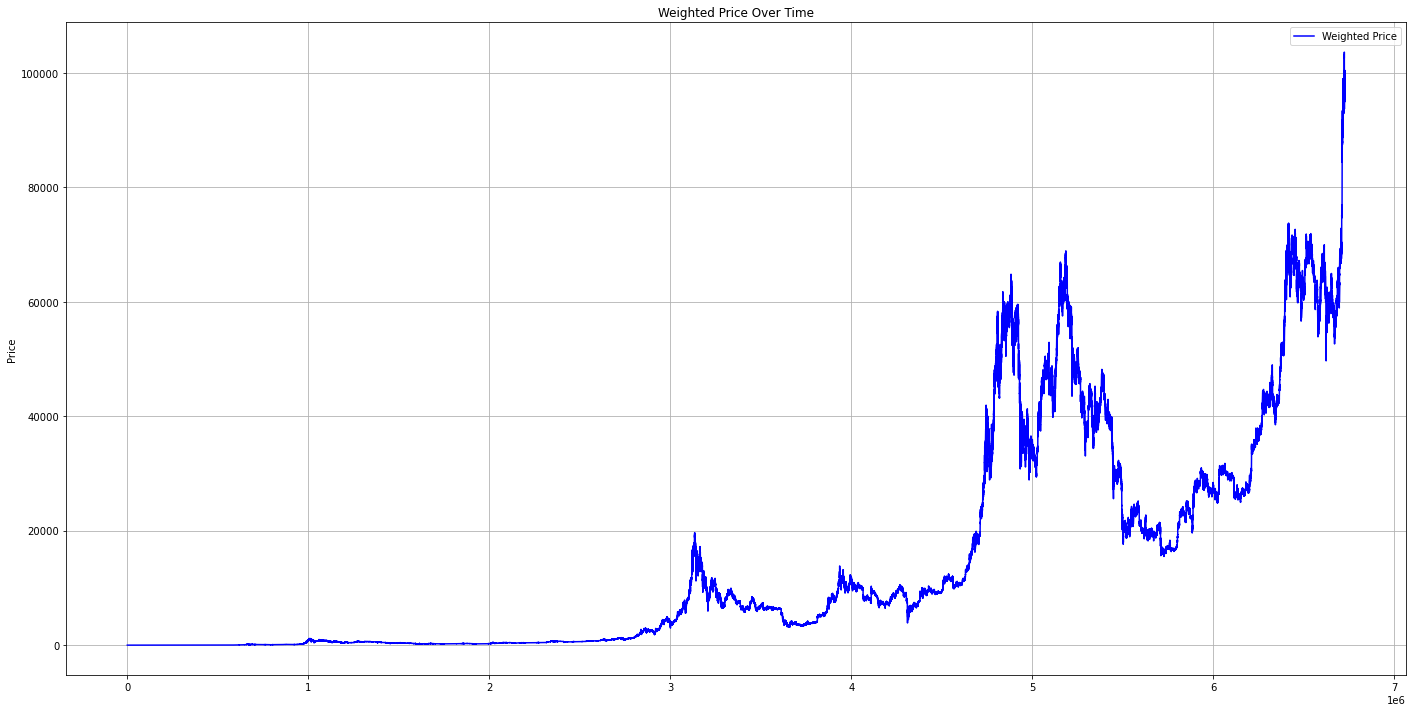

In [ ]:
# Weighted Price over time
plt.figure(figsize = (24, 12))
plt.plot(df['WTD_Price'], label = 'Weighted Price', color = 'blue')
plt.title('Weighted Price Over Time')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()

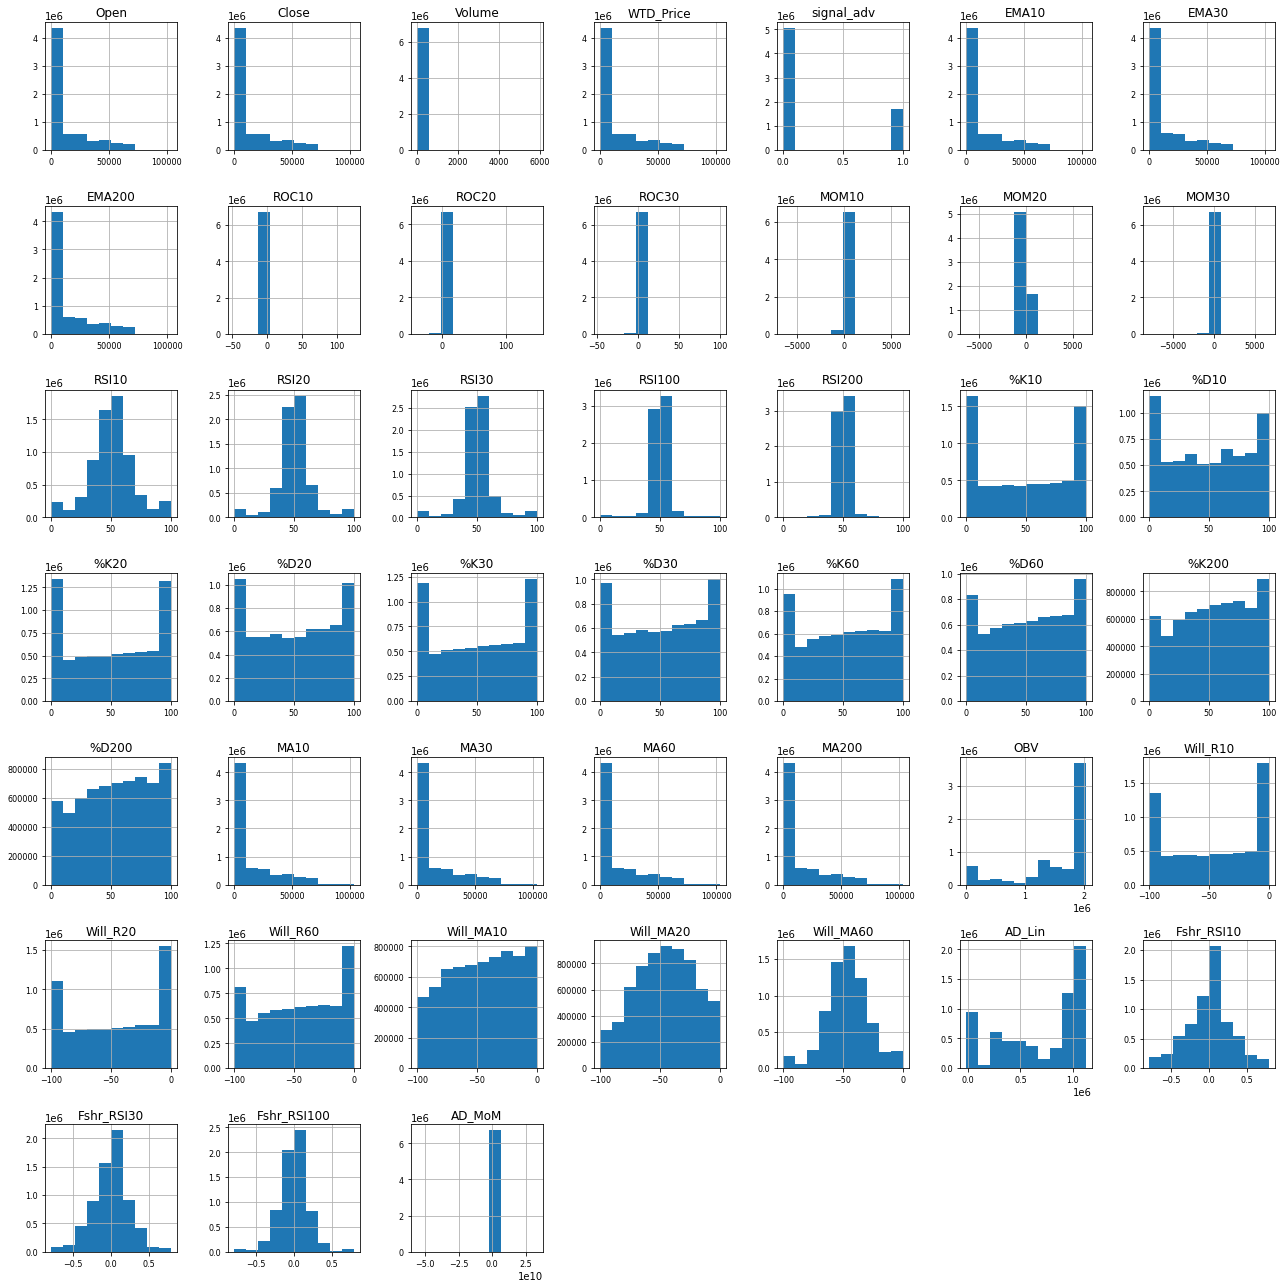

In [ ]:
# Plot histograms of all numerical features
df.hist(sharex=False, sharey=False, xlabelsize = 8, ylabelsize = 8, figsize=(18,18))
plt.tight_layout()
plt.show()

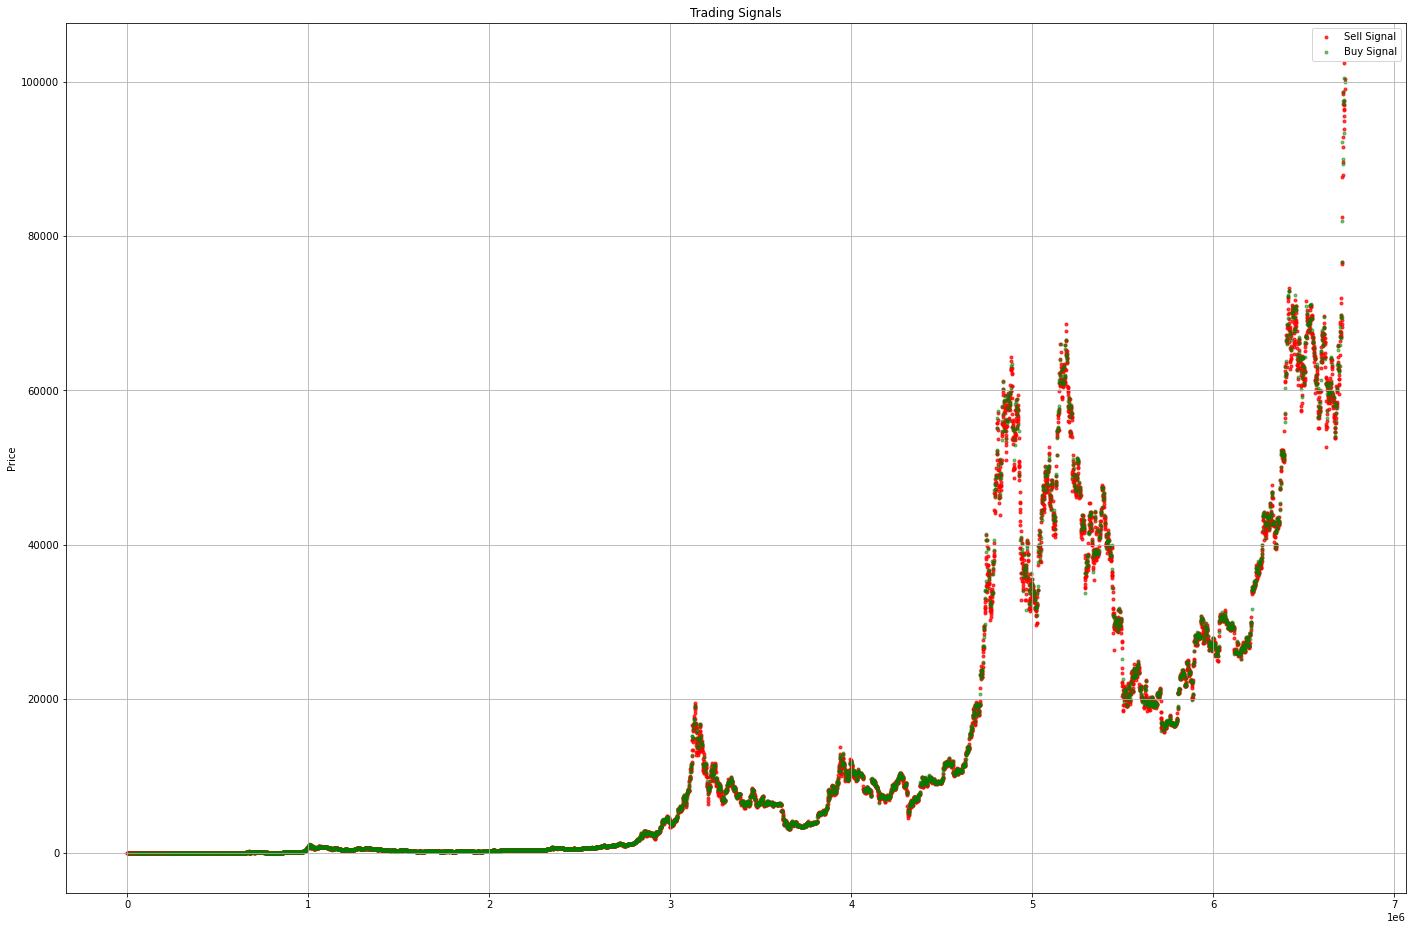

In [ ]:
plt.figure(figsize=(24,16))
buys = df[df['signal_adv'] == 1][::500]
sells = df[df['signal_adv'] == 0][::500]
plt.scatter(sells.index, sells['WTD_Price'], marker='.', color='red', label='Sell Signal', alpha=0.75)
plt.scatter(buys.index, buys['WTD_Price'], marker='.', color='green', label='Buy Signal', alpha=0.5)
plt.title('Trading Signals')
plt.ylabel('Price')
plt.grid(True)
plt.legend()

plt.show()

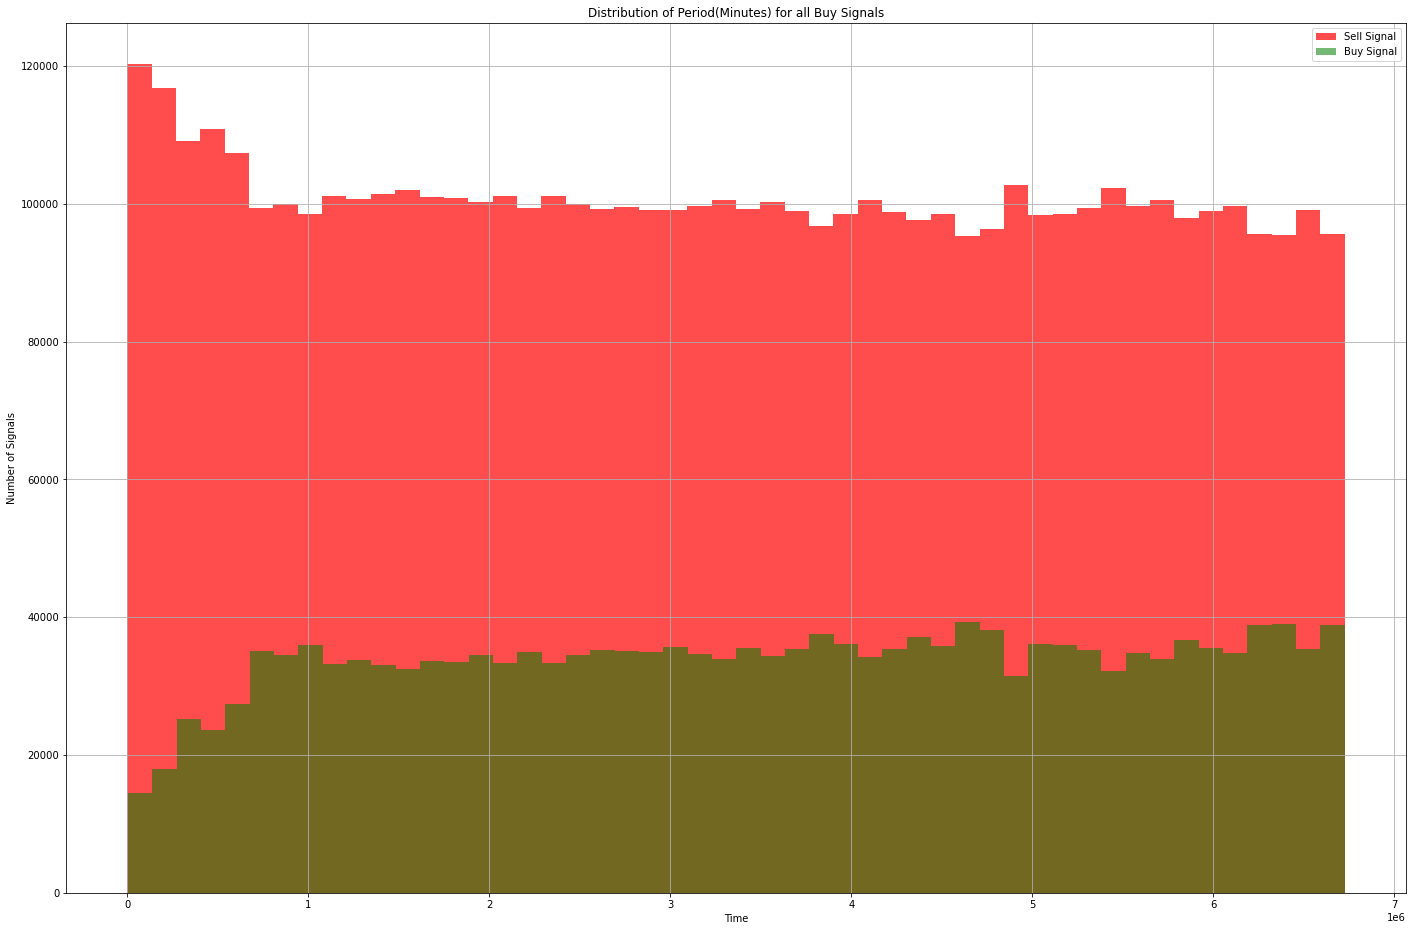

In [ ]:
plt.figure(figsize=(24, 16))
buys = df[df['signal_adv'] == 1]
sells = df[df['signal_adv'] == 0]
plt.hist(sells.index, bins = 50, color = 'red', alpha = 0.7, label = 'Sell Signal')
plt.hist(buys.index, bins = 50, color = 'green', alpha = 0.55, label = 'Buy Signal')
plt.title('Distribution of Period(Minutes) for all Buy Signals')
plt.ylabel('Number of Signals')
plt.xlabel('Time')
plt.grid(True)
plt.legend()

plt.show()

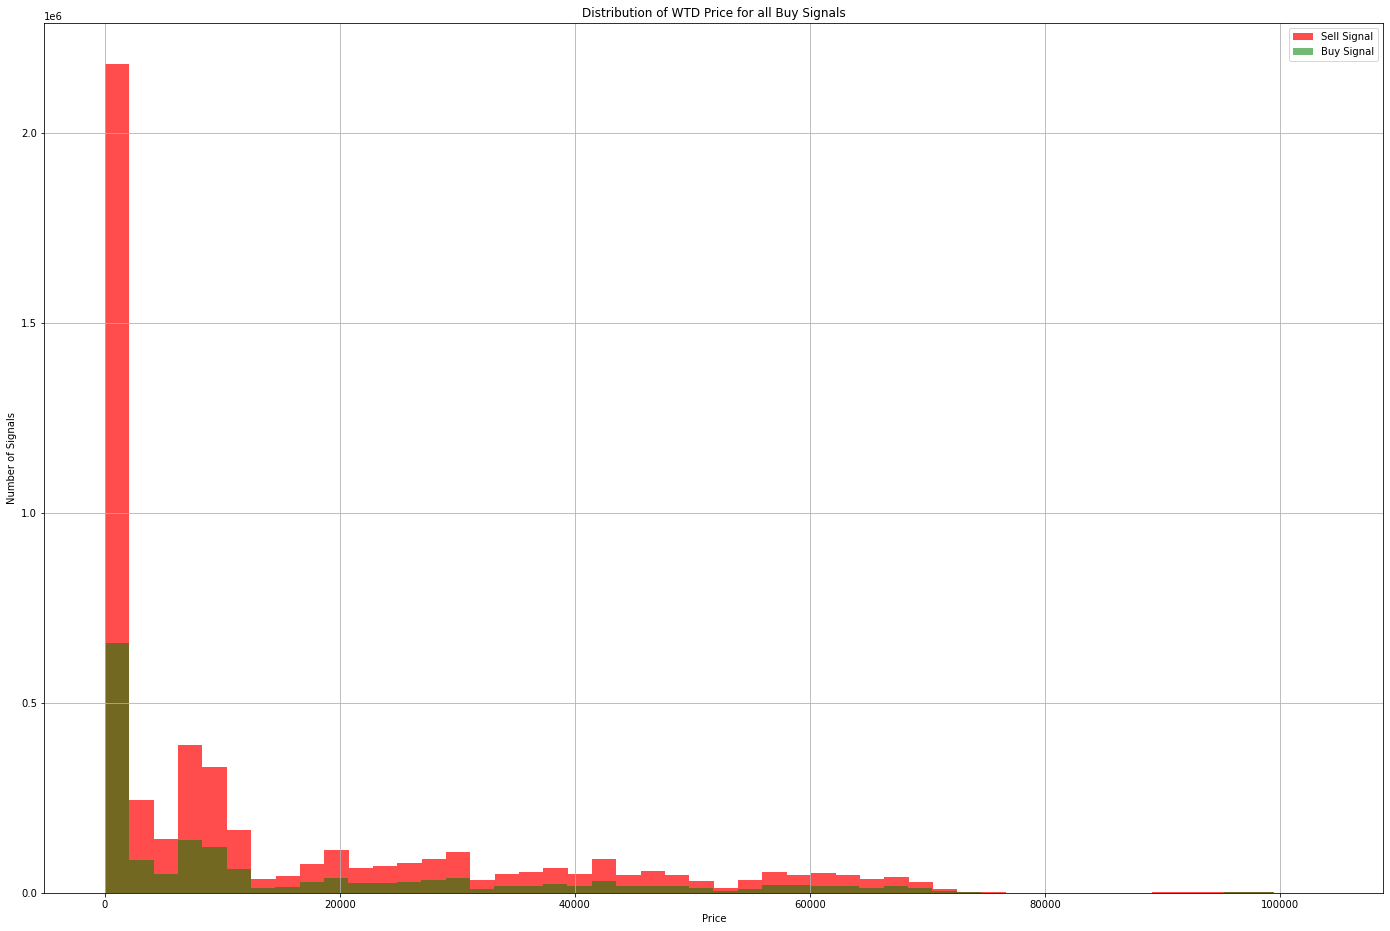

In [ ]:
plt.figure(figsize=(24, 16))
buys = df[df['signal_adv'] == 1]
sells = df[df['signal_adv'] == 0]
plt.hist(sells['WTD_Price'], bins = 50, color = 'red', alpha = 0.7, label = 'Sell Signal')
plt.hist(buys['WTD_Price'], bins = 50, color = 'green', alpha = 0.55, label = 'Buy Signal')
plt.title('Distribution of WTD Price for all Buy Signals')
plt.ylabel('Number of Signals')
plt.xlabel('Price')
plt.grid(True)
plt.legend()

plt.show()

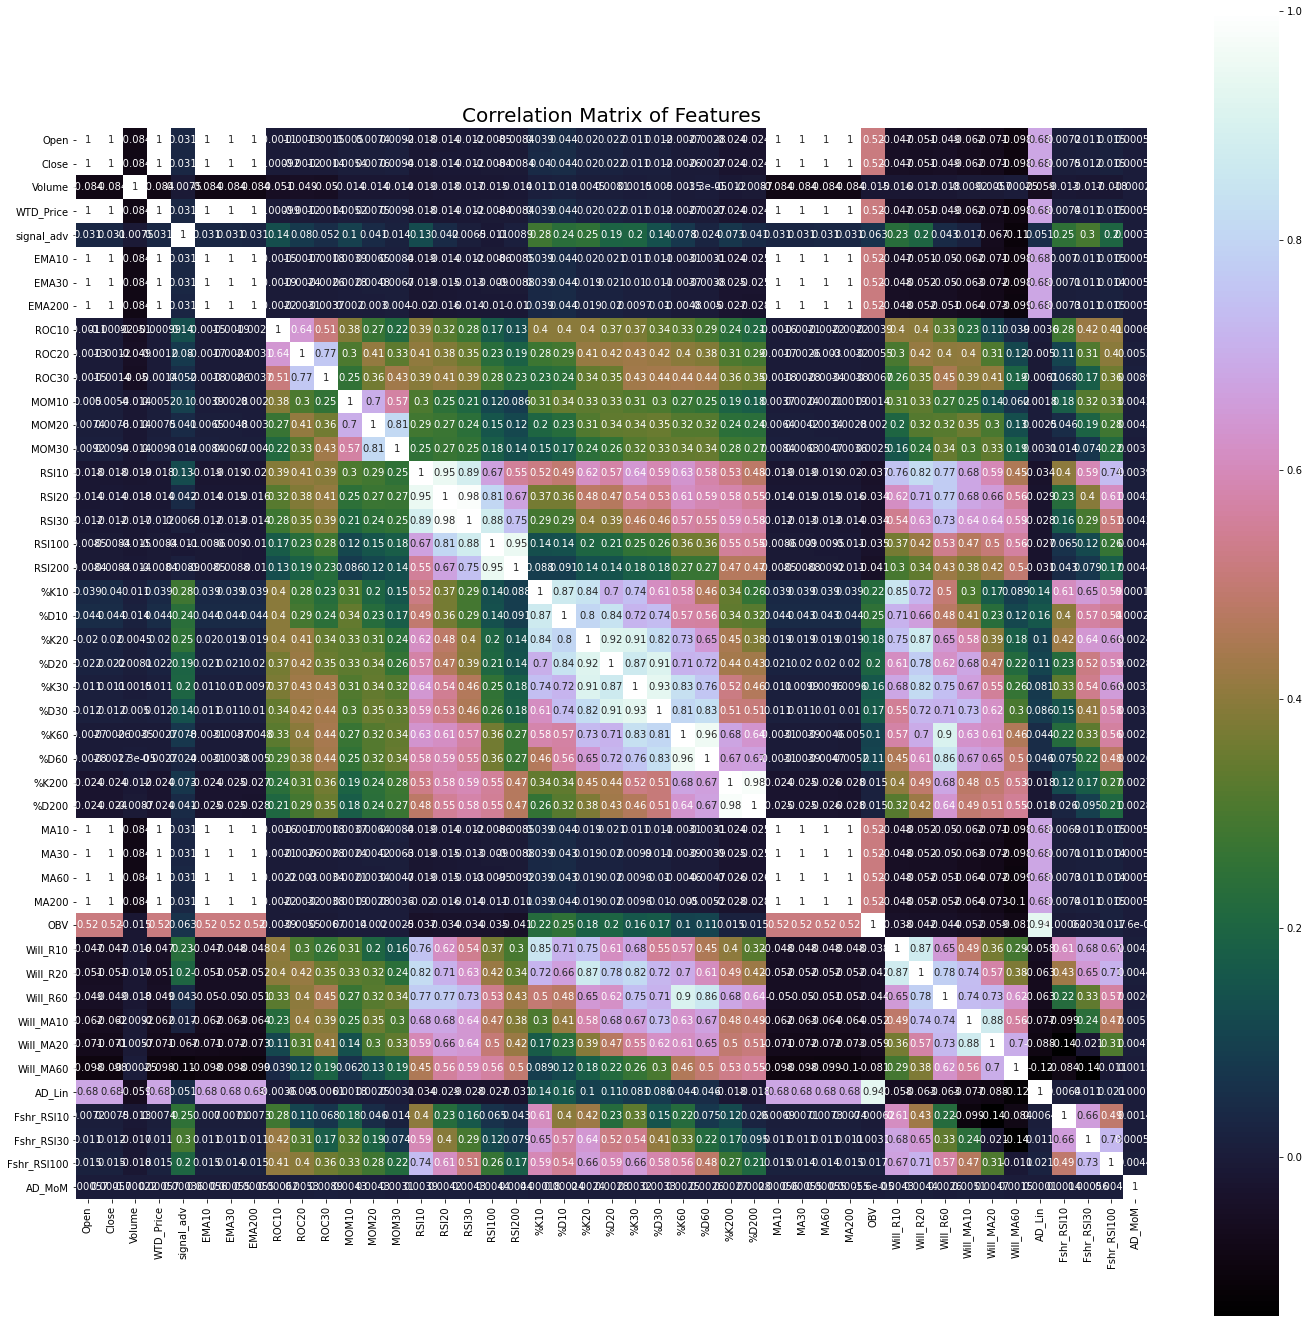

In [ ]:
# Correlation matrix heatmap
correlation = df.corr()
plt.figure(figsize=(24,24))
plt.title('Correlation Matrix of Features', fontsize=20)
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')
plt.show()

# 6. Evaluate Algorithms and Models


*   train/test split (on 250,000 instead of full dataset due to computational efficiency)
*   compute SVD to also reduce resources and find impacts of features
*   compare models and algorithms



In [ ]:
subset_df = df.iloc[-250000:]
y = subset_df['signal_adv']
X = subset_df.loc[:, subset_df.columns != 'signal_adv']

seed = 1
val_size = 0.2
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = val_size,
                                                                random_state = seed
                                                                )

X_test = X_validation
y_test = y_validation

In [ ]:
scaler = StandardScaler().fit(X_train)

rescaledDataset = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns, index = X_train.index)

X_train.dropna(how='any', inplace=True)
rescaledDataset.dropna(how='any', inplace=True)

print (rescaledDataset.shape[1])

44


Variance preserved by first 21 components == 99.55%


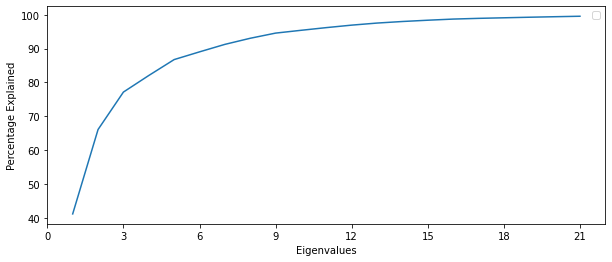

In [ ]:
from matplotlib.ticker import MaxNLocator
from sklearn.decomposition import TruncatedSVD

ncomps = 21

svd = TruncatedSVD(n_components=ncomps)
svd_fit = svd.fit(rescaledDataset)

plt_data = pd.DataFrame(svd_fit.explained_variance_ratio_.cumsum()*100)
plt_data.index = np.arange(1, len(plt_data) + 1)

y_pred = svd.fit_transform(rescaledDataset)

ax = plt_data.plot(kind='line', figsize=(10, 4))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel("Eigenvalues")
ax.set_ylabel("Percentage Explained")
ax.legend("")

print('Variance preserved by first 21 components == {:.2%}'.format(svd_fit.explained_variance_ratio_.cumsum()[-1]))

In [ ]:
dfsvd = pd.DataFrame(y_pred, columns=['c{}'.format(c) for c in range(ncomps)], index=rescaledDataset.index)
print(dfsvd.shape)
dfsvd.head()

(200000, 21)


,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c11,c12,c13,c14,c15,c16,c17,c18,c19,c20
6606855,0.469614,-0.537964,0.166763,-3.274397,-1.171099,-0.327928,0.168837,0.379222,0.727505,-0.153137,...,-0.532712,0.932091,0.178200,-0.510096,0.048194,-0.008167,-0.207093,-0.167314,-0.064449,0.328482
6722935,-0.693406,11.800948,1.104516,0.582726,0.945527,0.844306,0.434784,1.867913,0.159730,0.570955,...,0.490890,0.521830,0.433469,0.317371,-0.001283,0.299268,-0.027463,-0.022898,0.038513,-0.115988
6560813,-6.177277,0.189855,-0.158633,1.680282,-2.177865,0.097550,-0.400776,-0.526104,0.009291,0.032058,...,0.733649,0.578567,-0.669704,-0.385828,0.002702,0.070437,0.025511,-0.044358,0.110000,-0.396687
6537677,-5.772680,2.382117,0.915264,0.160718,-1.637834,-0.268623,0.185826,0.345547,0.686716,0.331778,...,-0.271772,0.594355,-0.293821,-0.083247,0.706061,-0.036443,-0.049280,-0.092772,-0.141417,-0.272567
6667574,3.449533,-2.738436,3.623565,-1.686793,0.679758,0.179887,-1.098280,0.731956,0.876355,-0.332809,...,0.322286,-0.256609,0.627890,-0.562418,0.341905,-0.361310,0.251776,-0.019362,-0.373286,-0.084298


In [ ]:
svdcols = [c for c in dfsvd.columns if c[0] == 'c']

In [ ]:
X_SVD = dfsvd[svdcols].iloc[:,:ncomps]

In [ ]:
num_folds = 10
scoring = 'accuracy'
seed = 7

start_time = time.time()

kfold = KFold(n_splits=num_folds, random_state= seed, shuffle = True)

models =  RandomForestClassifier(n_jobs=-1)
cv_results_XTrain= cross_val_score(models, X_train, y_train, cv=kfold, scoring=scoring)
print("Time Without Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
cv_results_SVD = cross_val_score(models, X_SVD, y_train, cv=kfold, scoring=scoring)
print("Time with Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))

print("Result without dimensionality Reduction: %f (%f)" % (cv_results_XTrain.mean(), cv_results_XTrain.std()))
print("Result with dimensionality Reduction: %f (%f)" % (cv_results_SVD.mean(), cv_results_SVD.std()))

Time Without Dimensionality Reduction--- 68.8853690624237 seconds ---
Time with Dimensionality Reduction--- 50.90483474731445 seconds ---
Result without dimensionality Reduction: 0.808835 (0.002763)
Result with dimensionality Reduction: 0.797195 (0.002816)


In [ ]:
# Define a suite of baseline models

models = []
models.append(('LR', LogisticRegression(n_jobs = -1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('NN', MLPClassifier()))
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
models.append(('RF', RandomForestClassifier(n_jobs = -1)))

# Evaluate each model using K-fold cross-validation
num_folds = 10
seed = 7
results_acc = []
names_acc = []
results_f1 = []
names_f1 = []
results_roc_auc = []
names_roc_auc = []

In [ ]:
scoring = 'accuracy'
print("Baseline Model Accuracy:")
times_acc = []
for name, model in models:
    start_time = time.time()
    kfold = KFold(n_splits = num_folds,
                random_state = seed,
                shuffle = True
                )

    cv_results_acc = cross_val_score(model,
                                X_SVD,
                                y_train,
                                cv = kfold,
                                scoring = scoring
                                )
    end_time = time.time()
    model_time = end_time - start_time
    times_acc.append(model_time)
    results_acc.append(cv_results_acc)
    names_acc.append(name)
    print(f"{name}: Mean Acc Score= {cv_results_acc.mean():.4f}, Std Acc Score= {cv_results_acc.std():.4f}, Comp Time= {model_time:.1f}s")

Baseline Model Accuracy:
LR: Mean Acc Score= 0.7617, Std Acc Score= 0.0020, Comp Time= 28.7s
LDA: Mean Acc Score= 0.7613, Std Acc Score= 0.0023, Comp Time= 2.6s
KNN: Mean Acc Score= 0.7868, Std Acc Score= 0.0021, Comp Time= 472.0s
CART: Mean Acc Score= 0.7120, Std Acc Score= 0.0043, Comp Time= 41.1s
NB: Mean Acc Score= 0.7346, Std Acc Score= 0.0032, Comp Time= 0.7s
NN: Mean Acc Score= 0.8036, Std Acc Score= 0.0028, Comp Time= 652.2s
AB: Mean Acc Score= 0.7643, Std Acc Score= 0.0019, Comp Time= 193.2s
GBM: Mean Acc Score= 0.7778, Std Acc Score= 0.0022, Comp Time= 863.7s
RF: Mean Acc Score= 0.7974, Std Acc Score= 0.0020, Comp Time= 43.7s


In [ ]:
#Baseline Model Accuracy:
#LR: Mean Acc Score= 0.7617, Std Acc Score= 0.0020, Comp Time= 13.3s
#LDA: Mean Acc Score= 0.7613, Std Acc Score= 0.0023, Comp Time= 4.2s
#KNN: Mean Acc Score= 0.7868, Std Acc Score= 0.0021, Comp Time= 14.7s
#CART: Mean Acc Score= 0.7105, Std Acc Score= 0.0026, Comp Time= 60.4s
#NB: Mean Acc Score= 0.7346, Std Acc Score= 0.0032, Comp Time= 0.4s
#NN: Mean Acc Score= 0.8031, Std Acc Score= 0.0029, Comp Time= 833.3s
#AB: Mean Acc Score= 0.7568, Std Acc Score= 0.0019, Comp Time= 217.5s
#GBM: Mean Acc Score= 0.7783, Std Acc Score= 0.0026, Comp Time= 1160.2s
#RF: Mean Acc Score= 0.7969, Std Acc Score= 0.0021, Comp Time= 113.8s

In [ ]:
models = []
times_f1 = []
models.append(('LR', LogisticRegression(n_jobs = -1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('NN', MLPClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RF', RandomForestClassifier(n_jobs = -1)))
scoring = 'f1'
print("Baseline Model F1:")
for name, model in models:
    start_time = time.time()
    kfold = KFold(n_splits = num_folds,
                random_state = seed,
                shuffle = True
                )

    cv_results_f1 = cross_val_score(model,
                                X_SVD,
                                y_train,
                                cv = kfold,
                                scoring = scoring
                                )
    end_time = time.time()
    model_time = end_time - start_time
    times_f1.append(model_time)
    results_f1.append(cv_results_f1)
    names_f1.append(name)
    print(f"{name}: Mean F1 Score= {cv_results_f1.mean():.4f}, Std F1 Score= {cv_results_f1.std():.4f}, Comp Time= {model_time:.1f}s")

Baseline Model F1:
LR: Mean F1 Score= 0.4261, Std F1 Score= 0.0045, Comp Time= 22.9s
LDA: Mean F1 Score= 0.4213, Std F1 Score= 0.0051, Comp Time= 2.2s
NN: Mean F1 Score= 0.6027, Std F1 Score= 0.0091, Comp Time= 532.6s
KNN: Mean F1 Score= 0.5750, Std F1 Score= 0.0031, Comp Time= 406.2s
RF: Mean F1 Score= 0.5394, Std F1 Score= 0.0050, Comp Time= 42.8s


In [ ]:
scoring = 'roc_auc'
models = []
times_roc_auc = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('RF', RandomForestClassifier(n_jobs = -1)))
print("Baseline Model ROC AUC:")
for name, model in models:
    start_time = time.time()
    kfold = KFold(n_splits = num_folds,
                random_state = seed,
                shuffle = True
                )

    cv_results_roc_auc = cross_val_score(model,
                                X_SVD,
                                y_train,
                                cv = kfold,
                                scoring = scoring
                                )
    end_time = time.time()
    model_time = end_time - start_time
    times_roc_auc.append(model_time)
    results_roc_auc.append(cv_results_roc_auc)
    names_roc_auc.append(name)
    print(f"{name}: Mean roc_auc Score= {cv_results_roc_auc.mean():.4f}, Std roc_auc Score= {cv_results_roc_auc.std():.4f}, Comp Time= {model_time:.1f}s")

Baseline Model ROC AUC:
KNN: Mean roc_auc Score= 0.8005, Std roc_auc Score= 0.0028, Comp Time= 409.1s
RF: Mean roc_auc Score= 0.8282, Std roc_auc Score= 0.0016, Comp Time= 42.2s


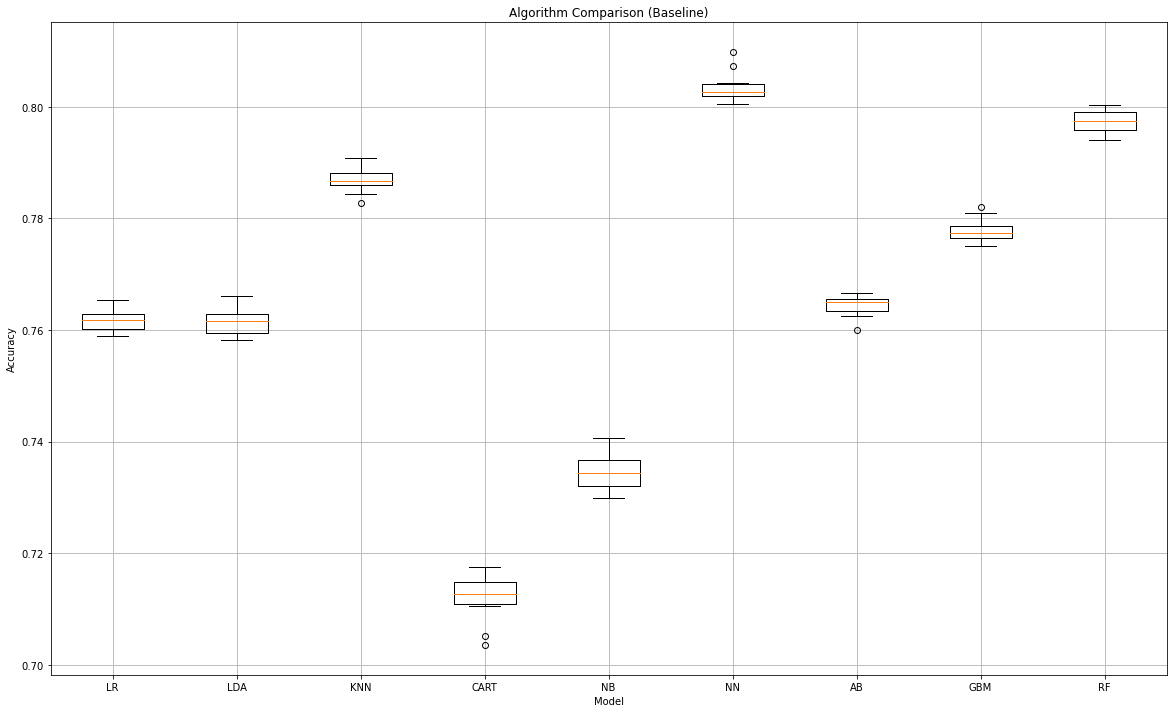

In [ ]:
# Compare Algorithms
plt.figure(figsize=(20,12))
plt.boxplot(results_acc, labels = names_acc)
plt.title('Algorithm Comparison (Baseline)')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

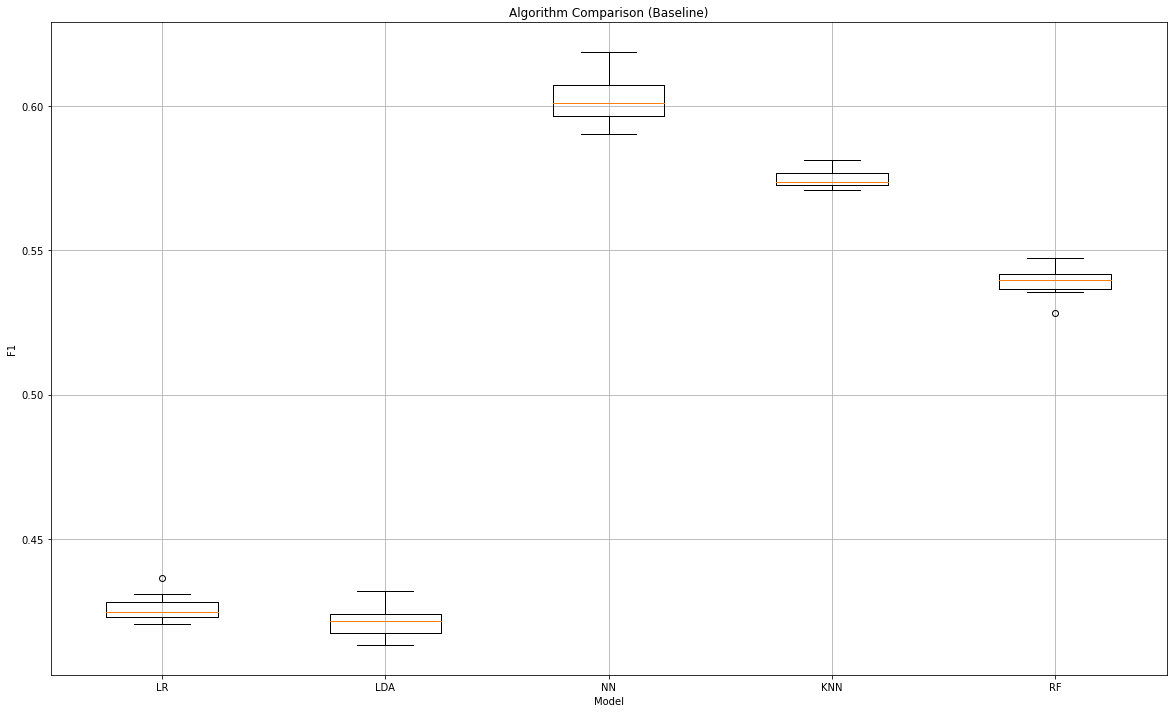

In [ ]:
# Compare Algorithms
plt.figure(figsize=(20,12))
plt.boxplot(results_f1, labels = names_f1)
plt.title('Algorithm Comparison (Baseline)')
plt.xlabel('Model')
plt.ylabel('F1')
plt.grid(True)
plt.show()

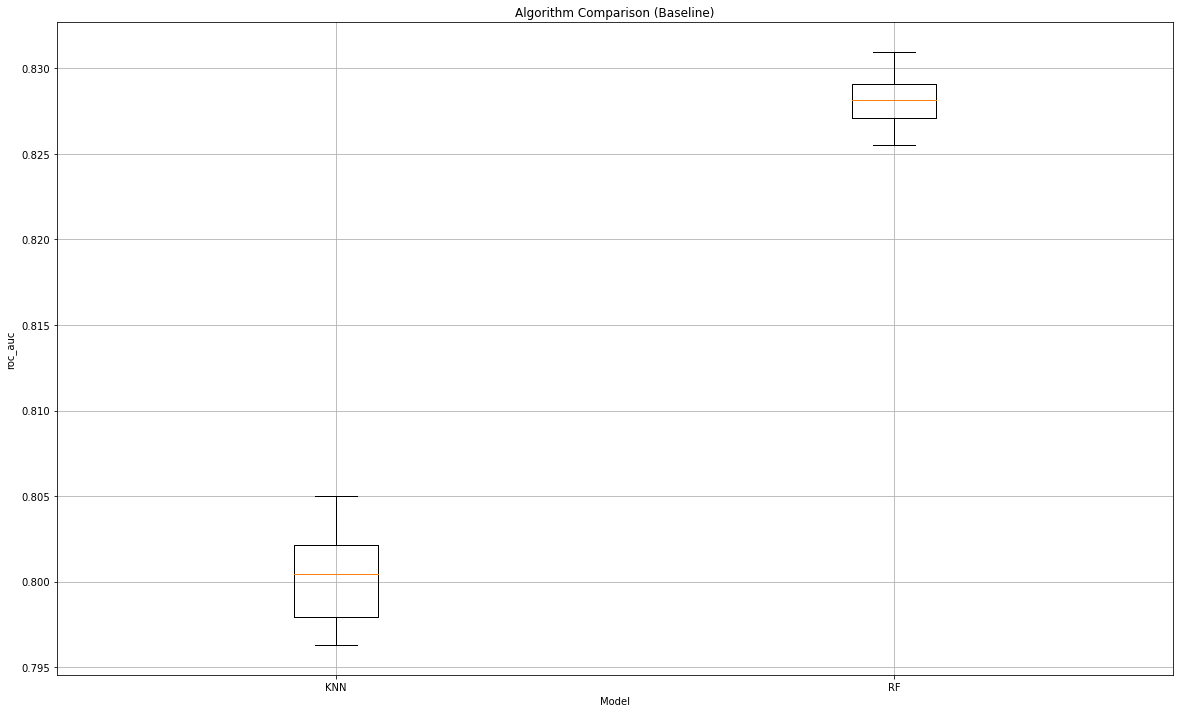

In [ ]:
# Compare Algorithms
plt.figure(figsize=(20,12))
plt.boxplot(results_roc_auc, labels = names_roc_auc)
plt.title('Algorithm Comparison (Baseline)')
plt.xlabel('Model')
plt.ylabel('roc_auc')
plt.grid(True)
plt.show()

# 7. Model Tuning and Grid Search
* tune random forest classifier parameters
* identify best parameters and run on non-SVD data to see which has higher accuracy to select as the best model

In [ ]:
# Grid Search: Random Forest Classifier
'''
n_estimators : int (default=100)
    The number of boosting stages to perform.
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators.
    The maximum depth limits the number of nodes in the tree.
    Tune this parameter for best performance; the best value depends on the interaction of the input variables
criterion : string, optional (default=”gini”)
    The function to measure the quality of a split.
    Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.

'''
tune_results = []
num_folds = 10
seed = 7
scoring = 'accuracy'
#scaler = StandardScaler().fit(X_train)
#rescaledX = scaler.transform(X_train)
param_grid = {
    'n_estimators': [20, 100, 200],
    'max_depth': [5, 20],
    'criterion': ["gini", "entropy"],
}
model = RandomForestClassifier(n_jobs = -1
                               )

kfold = KFold(n_splits = num_folds,
               shuffle = True,
               random_state = seed
              )

grid = GridSearchCV(estimator = model,
                    param_grid = param_grid,
                    scoring = scoring,
                    cv = kfold,
                    n_jobs = 4
                    )

grid_result = grid.fit(X_SVD, y_train)
cv_res = grid_result.cv_results_
print("\nRandom Forest Grid Search Results:")
print(f"Best Score: {grid_result.best_score_:.4f} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))


Random Forest Grid Search Results:
Best Score: 0.7978 using {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 200}
#10 0.742390 (0.003559) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#8 0.742580 (0.002393) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 100}
#7 0.743115 (0.002670) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 200}
#6 0.788270 (0.002706) with: {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 20}
#4 0.796205 (0.002488) with: {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 100}
#1 0.797805 (0.002833) with: {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 200}
#9 0.742500 (0.004296) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#11 0.742280 (0.001743) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 100}
#12 0.741935 (0.003285) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 200}
#5 0.788935 (0.002319) with: {'criterion': 'entropy', 'max_depth': 20, 'n_e

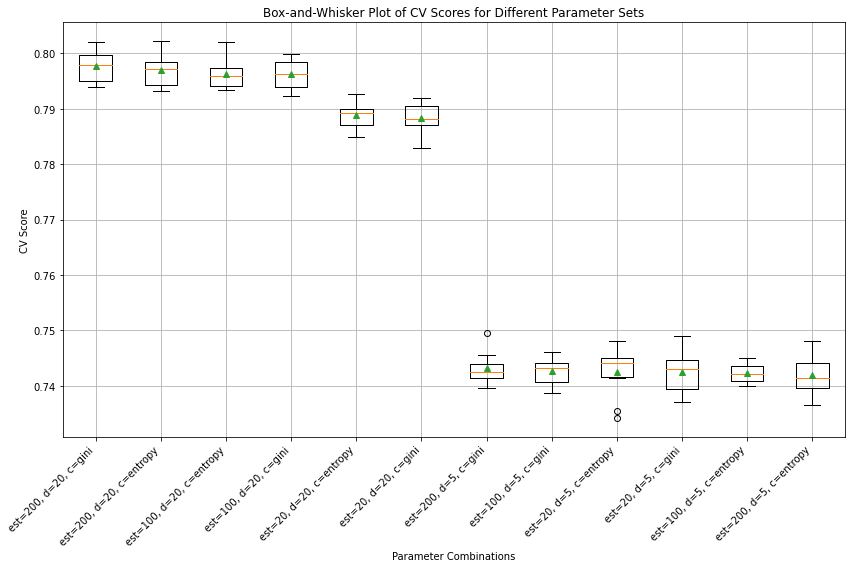

In [ ]:
cv_res_df = pd.DataFrame(grid_result.cv_results_)

split_cols = [col for col in cv_res_df.columns if col.startswith('split') and col.endswith('test_score')]
cv_res_df['mean_score'] = cv_res_df[split_cols].mean(axis=1)
cv_res_df_sorted = cv_res_df.sort_values('mean_score', ascending=False)

all_scores = []
param_labels = []
for i, row in cv_res_df_sorted.iterrows():
    scores = row[split_cols].values
    all_scores.append(scores)
    # Short label with key params. Adjust formatting as needed.
    p = row['params']
    label = f"est={p['n_estimators']}, d={p['max_depth']}, c={p['criterion']}"
    param_labels.append(label)

# Plot boxplot for all parameter sets
plt.figure(figsize=(12, 8))
plt.boxplot(all_scores, labels=param_labels, showmeans=True)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Parameter Combinations')
plt.ylabel('CV Score')
plt.title('Box-and-Whisker Plot of CV Scores for Different Parameter Sets')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
top_n = 10
feature_names = df.columns

for i, component in enumerate(svd.components_):
    # Sort features by their absolute value in descending order
    sorted_idx = np.argsort(np.abs(component))[::-1]

    # Get the top n indices
    top_features_idx = sorted_idx[:top_n]

    # Get the corresponding feature names
    top_features = [feature_names[idx] for idx in top_features_idx]

    # Retrieve the corresponding loadings (can help you know if they are positive/negative influences)
    top_loadings = component[top_features_idx]

    print(f"Component {i+1}:")
    for f, l in zip(top_features, top_loadings):
        print(f"  {f}: {l:.4f}")
    print("\n")

Component 1:
  RSI10: 0.2265
  MOM30: 0.2204
  %D20: 0.2183
  RSI20: 0.2168
  %K30: 0.2143
  Will_R20: 0.2087
  %D30: 0.2087
  %K20: 0.2083
  %D10: 0.2080
  Will_R10: 0.2080


Component 2:
  MA10: 0.3143
  EMA10: 0.3143
  MA30: 0.3143
  %D200: 0.3142
  signal_adv: 0.3142
  WTD_Price: 0.3141
  Close: 0.3141
  EMA30: 0.3140
  MA60: 0.3139
  MA200: 0.2381


Component 3:
  Fshr_RSI10: -0.3387
  AD_Lin: -0.3150
  Will_MA20: 0.2727
  RSI200: -0.2685
  OBV: -0.2685
  Fshr_RSI30: -0.2309
  %K200: 0.2274
  %K10: -0.2213
  RSI30: 0.2176
  Will_MA10: 0.2089


Component 4:
  RSI100: 0.3764
  RSI30: 0.3328
  Will_R60: -0.3122
  Fshr_RSI100: -0.3031
  Will_MA10: -0.2949
  %D60: 0.2736
  AD_Lin: 0.2661
  %K200: 0.2572
  %K30: -0.2093
  EMA200: 0.1986


Component 5:
  MOM10: -0.3920
  ROC10: -0.3753
  ROC30: -0.3274
  MOM20: -0.3260
  ROC20: -0.3188
  EMA200: -0.2960
  %D60: 0.2110
  Will_MA20: 0.2104
  %K200: 0.2028
  %D30: 0.1635


Component 6:
  Volume: 0.9239
  Will_MA60: 0.2570
  MA200: 0.2299
  

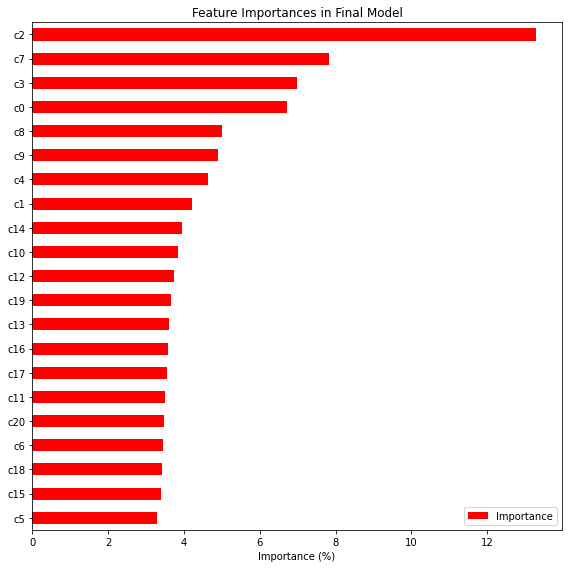

In [ ]:
# Feature Importance Visualization
final_model = grid_result.best_estimator_
if hasattr(final_model, 'feature_importances_'):
    Importance = pd.DataFrame({'Importance':final_model.feature_importances_*100}, index=X_SVD.columns)
    Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', figsize=(8,8))
    plt.title('Feature Importances in Final Model')
    plt.xlabel('Importance (%)')
    plt.tight_layout()
    plt.show()

In [ ]:
component_wts = final_model.feature_importances_
component_wts

array([0.06727899, 0.04209982, 0.13296291, 0.06991219, 0.0464024 ,
       0.03281619, 0.03439325, 0.07825297, 0.05011963, 0.04888719,
       0.03835374, 0.03498964, 0.0374295 , 0.03605751, 0.03953186,
       0.03389542, 0.03563694, 0.03554668, 0.03406763, 0.03654379,
       0.03482174])

In [ ]:
svd.components_

array([[ 1.40180695e-02, -1.27255556e-03,  1.38793312e-02,
         1.26405921e-02,  1.10026359e-02,  8.45789766e-03,
         1.59430880e-01,  1.79020077e-01,  1.71149186e-01,
         1.59424638e-01,  1.74510002e-01,  1.65834162e-01,
         2.20449111e-01,  2.26518911e-01,  2.16788990e-01,
         1.54901752e-01,  1.16335928e-01,  1.69824551e-01,
         1.79412605e-01,  2.07995580e-01,  2.08340729e-01,
         2.18309240e-01,  2.14272157e-01,  2.08743786e-01,
         2.00924964e-01,  1.54117336e-01,  1.46389407e-01,
         1.25145322e-02,  1.05438292e-02,  9.35078188e-03,
         8.04701547e-03,  1.08388342e-02,  1.69824551e-01,
         2.07995580e-01,  2.08743786e-01,  1.89386930e-01,
         1.65041074e-01,  1.13336367e-01,  9.89864817e-03,
         6.91868234e-02,  1.26887298e-01,  1.83064790e-01,
         1.66235534e-01],
       [ 3.14068262e-01,  1.57387527e-02,  3.14083557e-01,
         3.14191501e-01,  3.14269479e-01,  3.14005886e-01,
        -9.11941093e-03, -5.37

In [ ]:
original_feature_importances = np.dot(component_wts, svd.components_)
original_feature_importances

array([ 0.01385295,  0.05091427,  0.01395272,  0.01398683,  0.01333658,
        0.01136529, -0.03160896, -0.03468473,  0.03566776,  0.04253679,
        0.0059887 ,  0.06657786,  0.00043918,  0.0360522 ,  0.05671104,
        0.05221664,  0.01745717,  0.01671497,  0.03989469, -0.0400102 ,
       -0.02372763, -0.02201057, -0.00327709,  0.05513117,  0.06993881,
        0.05286683,  0.06004625,  0.01410893,  0.0134947 ,  0.01200083,
        0.01043376,  0.00141335,  0.01671497, -0.0400102 ,  0.05513117,
       -0.00961967, -0.00735357,  0.06768046, -0.00209709, -0.06165239,
       -0.0405877 , -0.05279609, -0.02210752])

        feature  aggregated_importance
24         %D60               0.069939
37    Will_MA60               0.067680
11        MOM30               0.066578
39   Fshr_RSI10              -0.061652
26        %D200               0.060046
14        RSI30               0.056711
23         %K60               0.055131
34     Will_R60               0.055131
25        %K200               0.052867
41  Fshr_RSI100              -0.052796
15       RSI100               0.052217
1        Volume               0.050914
9         MOM10               0.042537
40   Fshr_RSI30              -0.040588
19         %K20              -0.040010


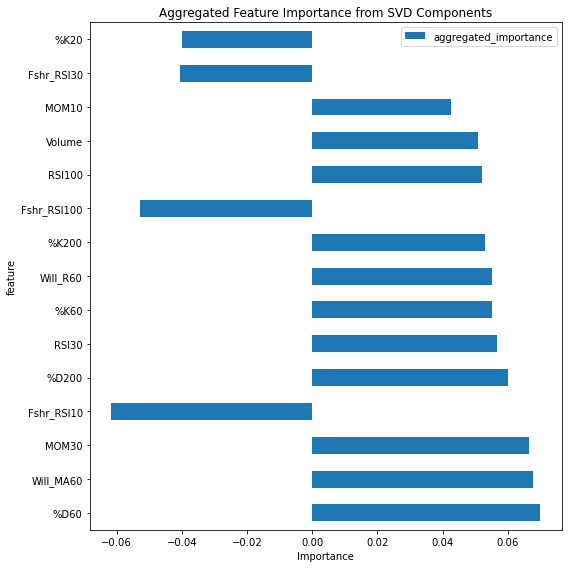

In [ ]:
aggregated_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'aggregated_importance': original_feature_importances
})

# Sort by absolute value if you just care about magnitude
aggregated_importance_df = aggregated_importance_df.reindex(
    aggregated_importance_df['aggregated_importance'].abs().sort_values(ascending=False).index
)

print(aggregated_importance_df.head(15))

# Optional: Plot the top features
aggregated_importance_df.head(15).plot(kind='barh', x='feature', y='aggregated_importance', figsize=(8,8))
plt.title("Aggregated Feature Importance from SVD Components")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [ ]:
#testing all features (non-SVD) - we will use the 2nd highest n_estimators to save on computation time
seed = 7
num_folds = 10
scoring = 'accuracy'
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

param_grid = {
    'n_estimators': [100],
    'max_depth': [15],
    'criterion': ["gini"],
}
model_full = RandomForestClassifier(n_jobs = -1
                               )

kfold = KFold(n_splits = num_folds,
               shuffle = True,
               random_state = seed
              )

grid = GridSearchCV(estimator = model_full,
                    param_grid = param_grid,
                    scoring = scoring,
                    cv = kfold,
                    n_jobs = 4
                    )

grid_result_full = grid.fit(rescaledX, y_train)
print("\nRandom Forest Grid Search Results:")
print(f"Best Score: {grid_result_full.best_score_:.4f} using {grid_result_full.best_params_}")


Random Forest Grid Search Results:
Best Score: 0.8028 using {'criterion': 'gini', 'max_depth': 15, 'n_estimators': 100}


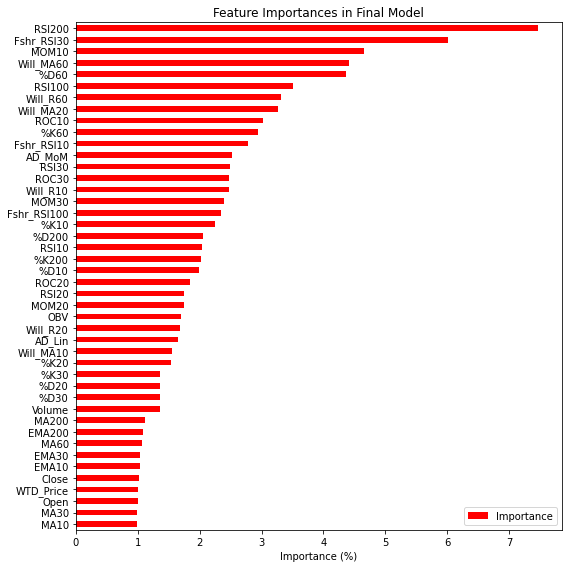

In [ ]:
#Feature importance graph on indicators (not SVD components)
final_model_full = grid_result_full.best_estimator_
if hasattr(final_model_full, 'feature_importances_'):
    Importance = pd.DataFrame({'Importance':final_model_full.feature_importances_*100}, index=X_train.columns)
    Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', figsize=(8,8))
    plt.title('Feature Importances in Final Model')
    plt.xlabel('Importance (%)')
    plt.tight_layout()
    plt.show()

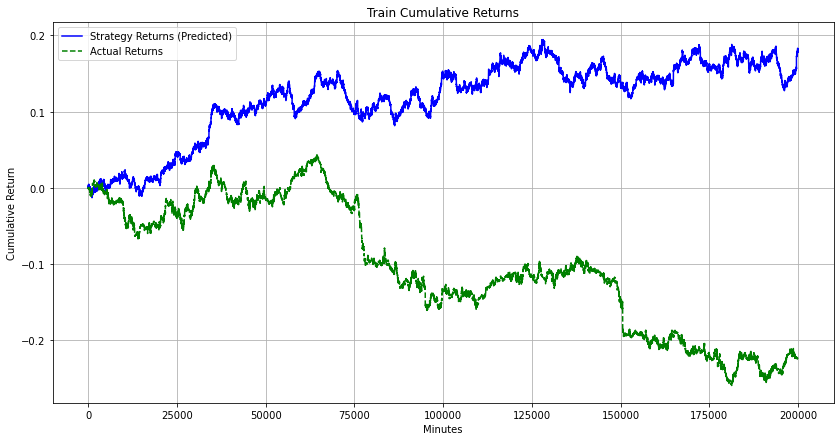

In [ ]:
# Create a new DataFrame to store signals and returns
insampledata = pd.DataFrame(index=X_train.index)

# Sort the index to ensure time-order
insampledata = insampledata.sort_index()

# Predictions and actual signals
insampledata['signal_pred'] = final_model_full.predict(rescaledX)  # Predicted signals
insampledata['signal_actual'] = y_train  # Actual signals

# Calculate market returns: percentage return from Open to Close
insampledata['Market Returns'] = (
    (X_train['Close'].shift(-1) - X_train['Open'].shift(-1)) / X_train['Open'].shift(-1)
).fillna(0)
insampledata['Market cumrets'] = (1 + insampledata['Market Returns']).cumprod()-1

# Calculate market returns: percentage return from Open to Close
insampledata['Close to Close'] = X_train['Close'].pct_change()
insampledata['Close cumrets'] = (1 + insampledata['Close to Close']).cumprod()-1

# Calculate returns: Predicted and Actual
insampledata['Strategy Returns'] = (
    insampledata['Market Returns'] * insampledata['signal_pred']
)
insampledata['Actual Returns'] = (
    insampledata['Market Returns'] * insampledata['signal_actual']
)

# Drop any NaN values to avoid issues in calculations
insampledata = insampledata.dropna()

# Calculate cumulative returns for strategy and actual signals
insampledata['Cumulative Strategy Returns'] = (1 + insampledata['Strategy Returns']).cumprod()-1
insampledata['Cumulative Actual Returns'] = (1 + insampledata['Actual Returns']).cumprod()-1

# Reset the index for cleaner plotting
insampledata = insampledata.reset_index(drop=True)

# Plot the cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(insampledata.index, insampledata['Cumulative Strategy Returns'],
         label='Strategy Returns (Predicted)', color='blue')
plt.plot(insampledata.index, insampledata['Cumulative Actual Returns'],
         label='Actual Returns', linestyle='--', color='green')

# Add title, labels, and legend
plt.title("Train Cumulative Returns")
plt.xlabel("Minutes")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()
#insampledata.head(50)

# 8. Final Model Testing
* monte carlo simulations
* white reality check
* calculate final test accuracy, classification scoring
* SHAP plot
* test cumulative returns

In [ ]:
#MONTE CARLO SIMULATION
def monte_carlo_sim(model, X, y, n_simulations = 100):
    # Ensure target is 1D
    y = y.ravel() if isinstance(y, np.ndarray) and y.ndim > 1 else y

    act_score = model.score(X, y)
    sim_scores = []
    for _ in range(n_simulations):
        y_shuffle = np.random.permutation(y)

        temp_model = clone(model)

        temp_model.fit(X, y_shuffle)
        score = temp_model.score(X, y_shuffle)
        sim_scores.append(score)

    p_value = np.mean(np.array(sim_scores) >= act_score)
    return p_value

In [ ]:
# prepare model
# Retrieve the best model from GridSearch
final_model_full = grid_result_full.best_estimator_

# Evaluate on the test (validation) set
X_test_scaled = scaler.transform(X_test)
y_pred = final_model_full.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print("\nFinal Model Evaluation on Test Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Balanced Accuracy: {bal_acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Final Model Evaluation on Test Set:
Accuracy: 0.8008
Balanced Accuracy: 0.6933
F1 Score: 0.5578
Confusion Matrix:
[[33761  2275]
 [ 7683  6281]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87     36036
           1       0.73      0.45      0.56     13964

    accuracy                           0.80     50000
   macro avg       0.77      0.69      0.71     50000
weighted avg       0.79      0.80      0.78     50000



In [ ]:
p_value = monte_carlo_sim(
            final_model_full, X_test_scaled, y_test)
print(f"Monte Carlo p-value: {p_value:.7f}")
if p_value < 0.05:
    print("The observed accuracy is unlikely due to random chance (p < 0.05).")
else:
    print("The observed accuracy could be explained by random chance.")

Monte Carlo p-value: 0.0000000
The observed accuracy is unlikely due to random chance (p < 0.05).


In [ ]:
import statsmodels.api as sm
def detrendPrice(series):
    # fit linear model
    length = len(series)
    x = np.arange(length)
    y = np.array(series.values)
    x_const = sm.add_constant(x) #need to add intercept constant
    model = sm.OLS(y,x_const)
    result = model.fit()
    #y = pd.Series(y)
    #intercept = result.params[0]
    #beta = result.params[1]
    #print(result.summary())
    df = pd.DataFrame(result.params*x_const)
    y_hat = df[0] + df[1]
    #the residuals are the detrended prices
    resid = y-y_hat
    #add minimum necessary to residuals to avoid negative detrended prices
    resid = resid + abs(resid.min() + 1/10*resid.min())
    return resid

In [ ]:
def bootstrap(ser):
    ser.dropna(inplace=True)
    #ser = np.log(ser+1)
    arr = np.array(ser.values)
    alpha = .05*100 #significance alpha
    reps = 5000 #how many bootstrapings, 50000 limit if you have 8GB RAM


    percentile = 100-alpha
    ave = np.average(arr) #arithmetic mean


    print("average return %f" %ave)


    centered_arr = arr-ave
    n = len(centered_arr)
    #constructs 50000 alternative return histories and calculates their theoretical averages
    xb = np.random.choice(centered_arr, (n, reps), replace=True)
    mb = xb.mean(axis=0) #arithmetic mean


    #sorts the 50000 averages
    mb.sort()
    #calculates the 95% conficence interval (two tails) threshold for the theoretical averages
    print(np.percentile(mb, [2.5, 97.5]))
    threshold = np.percentile(mb, [percentile])[0]

    if ave > threshold:
        print("Reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)")
    else:
        print("Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)")

    #count will be the items i that are smaller than ave
    count_vals = 0
    for i in mb:
        count_vals += 1
        if i > ave:
            break

    #p is based on the count that are larger than ave so 1-count is needed:
    p = 1-count_vals/len(mb)


    print("p_value:")
    print(p)

    #histogram
    sr = pd.Series(mb)
    desc = sr.describe()
    count = desc[0]
    std = desc[2]
    minim = desc[3]
    maxim = desc[7]
    R = maxim-minim
    n = count
    s = std
    bins = int(round(R*(n**(1/3))/(3.49*std),0))
    fig = sr.hist(bins=bins)
    plt.axvline(x = ave, color = 'b', label = 'axvline - full height')

Results for WhiteRealityCheckFor1:
average return 0.015739
[-0.00259905  0.00269033]
Reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)
p_value:
0.0


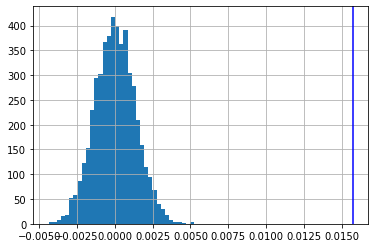

In [ ]:
X_test_scaled_df = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)
close = X_test_scaled_df['Close'].copy()
detrended_open = detrendPrice(close)
detrended_retFut1 = detrended_open.pct_change(periods=1).shift(-1).fillna(0)
detrended_syst_rets = detrended_retFut1 * pd.Series(y_pred).fillna(0)
print("Results for WhiteRealityCheckFor1:")
bootstrap(detrended_syst_rets)
plt.show()

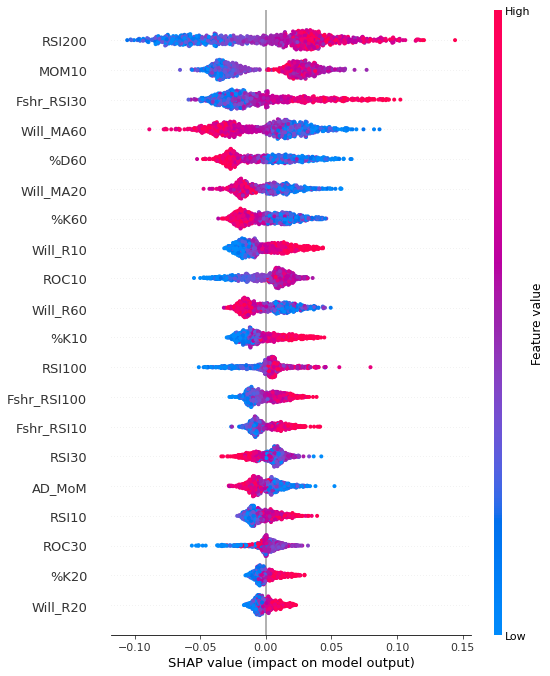

In [ ]:
explainer = shap.TreeExplainer(final_model_full, n_jobs = -1)
shap_values = explainer.shap_values(X_test_scaled[:1000])

if isinstance(shap_values, list):
    shap.summary_plot(shap_values[1], X_test_scaled[:1000], feature_names=X_test_scaled_df.columns)
else:
    shap.summary_plot(shap_values, X_test_scaled[:1000], feature_names=X_test_scaled_df.columns)

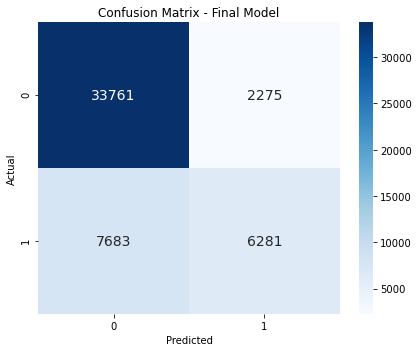

In [ ]:
# Plot Confusion Matrix heatmap
df_cm = pd.DataFrame(cm, columns=np.unique(y_test), index=np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize=(6,5))
sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 14}, fmt='d')
plt.title("Confusion Matrix - Final Model")
plt.tight_layout()
plt.show()

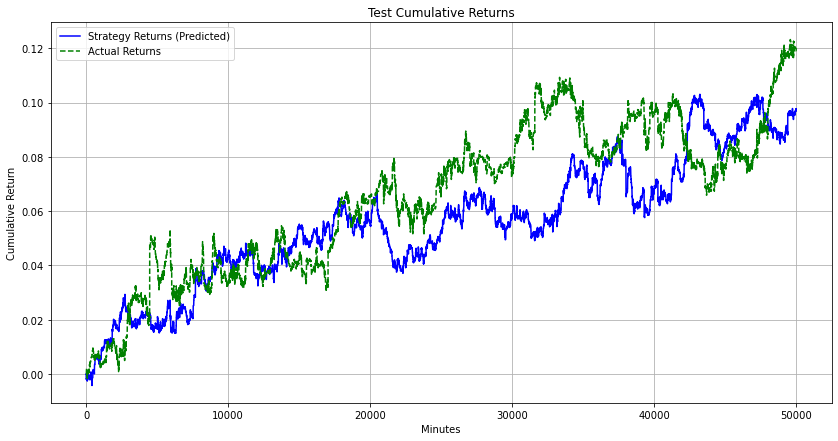

   signal_pred  signal_actual  Market Returns  Strategy Returns  \
0            0              0        0.000191               0.0   
1            0              0       -0.000066              -0.0   
2            0              0       -0.001776              -0.0   
3            0              0       -0.007521              -0.0   
4            0              0        0.000148               0.0   

   Actual Returns  Cumulative Strategy Returns  Cumulative Actual Returns  
0             0.0                          0.0                        0.0  
1            -0.0                          0.0                        0.0  
2            -0.0                          0.0                        0.0  
3            -0.0                          0.0                        0.0  
4             0.0                          0.0                        0.0  


In [ ]:
# Create a new DataFrame to store signals and returns
outofsampledata = pd.DataFrame(index=X_test.index)

# Sort the index to ensure time-order
outofsampledata = outofsampledata.sort_index()

# Predictions and actual signals
outofsampledata['signal_pred'] = y_pred  # Predicted signals
outofsampledata['signal_actual'] = y_test  # Actual signals

# Calculate market returns: percentage return from Open to Close
outofsampledata['Market Returns'] = (
    (X_test['Close'].shift(-1) - X_test['Open'].shift(-1)) / X_test['Open'].shift(-1)
).fillna(0)

# Calculate returns: Predicted and Actual
outofsampledata['Strategy Returns'] = (
    outofsampledata['Market Returns'] * outofsampledata['signal_pred']
)
outofsampledata['Actual Returns'] = (
    outofsampledata['Market Returns'] * outofsampledata['signal_actual']
)

# Drop any NaN values to avoid issues in calculations
outofsampledata = outofsampledata.dropna()

# Calculate cumulative returns for strategy and actual signals
outofsampledata['Cumulative Strategy Returns'] = (1 + outofsampledata['Strategy Returns']).cumprod()-1
outofsampledata['Cumulative Actual Returns'] = (1 + outofsampledata['Actual Returns']).cumprod()-1

# Reset the index for cleaner plotting
outofsampledata = outofsampledata.reset_index(drop=True)

# Plot the cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(outofsampledata.index, outofsampledata['Cumulative Strategy Returns'],
         label='Strategy Returns (Predicted)', color='blue')
plt.plot(outofsampledata.index, outofsampledata['Cumulative Actual Returns'],
         label='Actual Returns', linestyle='--', color='green')

# Add title, labels, and legend
plt.title("Test Cumulative Returns")
plt.xlabel("Minutes")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()

print(outofsampledata.head())

In [ ]:
# Compute Sharpe Ratio
sr_strategy = np.sqrt(1440 * 365) * np.mean(outofsampledata['Strategy Returns']) / np.std(outofsampledata['Strategy Returns'])
sr_actual = np.sqrt(1440 * 365) * np.mean(outofsampledata['Actual Returns']) / np.std(outofsampledata['Actual Returns'])

# Total minutes in a year for Bitcoin trading
annual_periods = 525600

# Length of your test dataset (in minutes)
total_periods = len(outofsampledata)

# Last cumulative returns for Strategy and Actual
strategy_cumret = outofsampledata['Cumulative Strategy Returns'].iloc[-1]
actual_cumret = outofsampledata['Cumulative Actual Returns'].iloc[-1]

# CAGR Calculation
strategy_cagr = ((1 + strategy_cumret) ** (annual_periods / total_periods)) - 1
actual_cagr = ((1 + actual_cumret) ** (annual_periods / total_periods)) - 1

# Add a column to identify profits and losses
outofsampledata['Profits'] = np.where(outofsampledata['Strategy Returns'] >= 0, outofsampledata['Strategy Returns'], 0)
outofsampledata['Losses'] = np.where(outofsampledata['Strategy Returns'] < 0, outofsampledata['Strategy Returns'], 0)

# Compute the Profit Ratio
profit_factor = outofsampledata['Profits'].sum() / np.abs(outofsampledata['Losses']).sum()

print("Out-of-sample Performance Metrics:")
print(f"Strategy Sharpe Ratio: {sr_strategy:.4f}")
print(f"Actual Sharpe Ratio: {sr_actual:.4f}")
print(f"Strategy CAGR: {strategy_cagr:.4f}")
print(f"Actual CAGR: {actual_cagr:.4f}")
print(f"Profit Factor: {profit_factor:.4f}")
print(f"Accuracy Score: {accuracy:.4f}")

Out-of-sample Performance Metrics:
Strategy Sharpe Ratio: 5.0783
Actual Sharpe Ratio: 4.7306
Strategy CAGR: 1.6607
Actual CAGR: 2.2587
Profit Factor: 1.0603
Accuracy Score: 0.8008
